In [618]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import plotly.express as px
import db_dtypes
import bigframes.pandas as bpd
from IPython.display import display, HTML
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import math
import statsmodels.api as sm
from datetime import datetime
from typing import Union
import logging
import sys


pre_holdout = """
WITH eligible_holdout_entities AS (
  SELECT
        entity_id
       ,`Release Date` as release_date
  FROM `logistics-data-storage-staging.long_term_pricing.global_holdout_rollout`
  WHERE `Release Date` < DATE_SUB(CURRENT_DATE(), INTERVAL EXTRACT(DAYOFWEEK FROM CURRENT_DATE())- 2 DAY)
),
customer_information AS (
  SELECT
         e.entity_id
        ,e.release_date
        ,customer_id
        ,is_customer_holdout
  FROM `fulfillment-dwh-production.cl.dps_holdout_users` AS d
  JOIN eligible_holdout_entities AS e
  ON d.entity_id = e.entity_id
  WHERE d.created_date >= DATE('2025-01-01')
  AND d.created_date >= e.release_date
  AND customer_id IS NOT NULL
)
SELECT 
     dps.entity_id
    ,dps.dps_customer_id
    ,ci.is_customer_holdout
    ,COUNT (DISTINCT platform_order_code) AS orders
    ,SUM(fully_loaded_gross_profit_eur) AS flgp
FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` dps
join customer_information ci on ci.entity_id = dps.entity_id and ci.customer_id = dps.dps_customer_id
WHERE created_date >= DATE('2024-10-01') and created_date <= DATE('2025-01-26')
and created_date < ci.release_date
AND platform_order_code IS NOT NULL
AND is_own_delivery
AND is_sent
AND vendor_vertical_parent in ('Restaurant','restaurant','restaurants')
GROUP BY 1,2,3

"""

post_holdout = """
WITH eligible_holdout_entities AS (
  SELECT
        entity_id
       ,`Release Date` as release_date
  FROM `logistics-data-storage-staging.long_term_pricing.global_holdout_rollout`
  WHERE `Release Date` < DATE_SUB(CURRENT_DATE(), INTERVAL EXTRACT(DAYOFWEEK FROM CURRENT_DATE())- 2 DAY)
),
customer_information AS (
  SELECT
         e.entity_id
        ,e.release_date
        ,customer_id
        ,is_customer_holdout
  FROM `fulfillment-dwh-production.cl.dps_holdout_users` AS d
  JOIN eligible_holdout_entities AS e
  ON d.entity_id = e.entity_id
  WHERE d.created_date >= DATE('2025-01-01')
  AND d.created_date >= e.release_date
  AND customer_id IS NOT NULL
)
SELECT 
     dps.entity_id
    ,dps.dps_customer_id
    ,ci.is_customer_holdout
    ,COUNT (DISTINCT platform_order_code) AS orders
    ,SUM(fully_loaded_gross_profit_eur) AS flgp
FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` dps
join customer_information ci on ci.entity_id = dps.entity_id and ci.customer_id = dps.dps_customer_id
WHERE created_date >= DATE('2025-01-01')
  AND created_date >= ci.release_date
  AND platform_order_code IS NOT NULL
  AND is_own_delivery
  AND is_sent
  AND vendor_vertical_parent in ('Restaurant','restaurant','restaurants')
GROUP BY 1,2,3
"""


grouped = """
WITH eligible_holdout_entities AS (
  SELECT
        entity_id
       ,`Release Date` as release_date
  FROM `logistics-data-storage-staging.long_term_pricing.global_holdout_rollout`
  WHERE `Release Date` < DATE_SUB(CURRENT_DATE(), INTERVAL EXTRACT(DAYOFWEEK FROM CURRENT_DATE())- 2 DAY)
),
customer_information AS (
  SELECT
         e.entity_id
        ,e.release_date
        ,is_customer_holdout
        ,count(distinct customer_id) users
  FROM `fulfillment-dwh-production.cl.dps_holdout_users` AS d
  JOIN eligible_holdout_entities AS e
  ON d.entity_id = e.entity_id
  WHERE d.created_date >= DATE('2025-01-01')
  and d.created_date < current_date
  AND d.created_date > e.release_date
  AND customer_id IS NOT NULL
  group by 1,2,3
)
SELECT 
     dps.entity_id
    ,dps.is_customer_holdout
    ,users
    ,COUNT (DISTINCT platform_order_code) AS orders
    ,SUM(fully_loaded_gross_profit_eur) AS flgp
    ,sum(profit_eur) profit_eur
    ,sum(revenue_eur) revenue_eur
    ,sum(gfv_eur) gfv_eur
    ,sum(delivery_costs_eur) delivery_cost
    ,sum(discount_dh_eur) discount_dh_eur
    ,sum(dps_delivery_fee_eur) dps_delivery_fee_eur
    ,COUNT (DISTINCT platform_order_code) / users opu
    ,SUM(fully_loaded_gross_profit_eur) / COUNT (DISTINCT platform_order_code) flgpo
    ,sum(profit_eur) / COUNT (DISTINCT platform_order_code) profit_per_order
    ,sum(revenue_eur) / COUNT (DISTINCT platform_order_code) revenue_per_order
    ,sum(delivery_costs_eur) / COUNT (DISTINCT platform_order_code) delivery_cost_per_order
    ,sum(gfv_eur) / COUNT (DISTINCT platform_order_code) gfv_eur_per_order
    ,sum(discount_dh_eur) / COUNT (DISTINCT platform_order_code) discount_per_order
    ,sum(dps_delivery_fee_eur) / COUNT (DISTINCT platform_order_code) delivery_fee_per_order
FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` dps
left join customer_information ci on ci.entity_id = dps.entity_id and ci.is_customer_holdout = dps.is_customer_holdout
WHERE created_date >= DATE('2025-01-01')
AND created_date > ci.release_date
AND created_date < current_date
AND platform_order_code IS NOT NULL
AND is_own_delivery
AND is_sent
AND dps_delivery_fee_local is not null
--AND vendor_vertical_parent in ('Restaurant','restaurant','restaurants')
GROUP BY 1,2,3

"""



entity_data = """
WITH eligible_holdout_entities AS (
  SELECT
        entity_id
       ,`Release Date` as release_date
  FROM `logistics-data-storage-staging.long_term_pricing.global_holdout_rollout`
  WHERE `Release Date` < DATE_SUB(CURRENT_DATE(), INTERVAL EXTRACT(DAYOFWEEK FROM CURRENT_DATE())- 2 DAY)
),
customer_information AS (
  SELECT
         e.entity_id
        ,e.release_date
        ,is_customer_holdout
        ,count(distinct customer_id) users
  FROM `fulfillment-dwh-production.cl.dps_holdout_users` AS d
  JOIN eligible_holdout_entities AS e
  ON d.entity_id = e.entity_id
  WHERE d.created_date >= DATE('2025-01-01')
  AND d.created_date >= e.release_date
  AND customer_id IS NOT NULL
  group by 1,2,3
)
select global_entity_id
      ,smto.is_customer_holdout
      ,users
      ,count(distinct pr.order_id) orders
      ,sum(gmv) gmv
      ,sum(gfv) gfv
      ,sum(analytical_profit) analytical_profit
      ,sum(revenue_net) revenue_net
      ,sum(delivery_costs) delivery_costs
      ,sum(delivery_fee_net)
from fulfillment-dwh-production.curated_data_shared_mkt.bima_order_profitability pr
left join `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` smto on smto.entity_id = pr.global_entity_id and smto.platform_order_code = pr.order_id
left join customer_information ci on ci.entity_id = pr.global_entity_id and ci.is_customer_holdout = smto.is_customer_holdout 
where order_date >= '2025-01-01'
and order_date > release_date
group by 1,2,3
"""


marketing_data = """
WITH eligible_holdout_entities AS (
  SELECT
        entity_id
       ,`Release Date` as release_date
  FROM `logistics-data-storage-staging.long_term_pricing.global_holdout_rollout`
  WHERE `Release Date` < DATE_SUB(CURRENT_DATE(), INTERVAL EXTRACT(DAYOFWEEK FROM CURRENT_DATE())- 2 DAY)
),
customer_information AS (
  SELECT
         e.entity_id
        ,e.release_date
        ,COUNT(DISTINCT CASE WHEN is_customer_holdout IS True THEN customer_id END) AS holdout_customers
        ,COUNT(DISTINCT CASE WHEN is_customer_holdout IS False THEN customer_id END) AS non_holdout_customers
        ,COUNT(DISTINCT customer_id) AS all_customers
  FROM `fulfillment-dwh-production.cl.dps_holdout_users` AS d
  JOIN eligible_holdout_entities AS e
  ON d.entity_id = e.entity_id
  WHERE d.created_date >= DATE('2025-01-01')
    AND customer_id NOT IN UNNEST(ARRAY(SELECT id FROM `fulfillment-dwh-production.cl._bad_dps_logs_ids`))
    AND d.created_date > e.release_date
    AND customer_id IS NOT NULL
  GROUP BY e.entity_id, e.release_date
), 
orders as (
select
      DATE_SUB(CURRENT_DATE(), INTERVAL EXTRACT(DAYOFWEEK FROM CURRENT_DATE()) - 2 DAY) AS analysis_week 
    ,global_entity_id
    ,release_date
    ,holdout_customers
    ,non_holdout_customers
    ,all_customers
    ,count(distinct case when dps.is_customer_holdout then op.order_id end) holdout_orders
    ,count(distinct case when dps.is_customer_holdout is false then op.order_id end) non_holdout_orders
    ,sum(case when dps.is_customer_holdout then op.gmv end) holdout_gmv
    ,sum(case when dps.is_customer_holdout is false then op.gmv end) non_holdout_gmv
    ,sum(case when dps.is_customer_holdout then op.gfv end) holdout_gfv
    ,sum(case when dps.is_customer_holdout is false then op.gfv end) non_holdout_gfv
    ,sum(case when dps.is_customer_holdout then op.analytical_profit end) flgp_holdout
    ,sum(case when dps.is_customer_holdout is false then op.analytical_profit end) flgp_non_holdout
    ,sum(case when dps.is_customer_holdout then op.revenue_net end) holdout_revenue_net
    ,sum(case when dps.is_customer_holdout is false then op.revenue_net end) non_holdout_revenue_net
    ,sum(case when dps.is_customer_holdout then op.delivery_costs end) holdout_delivery_costs
    ,sum(case when dps.is_customer_holdout is false then op.delivery_costs end) non_holdout_delivery_costs
    ,sum(case when dps.is_customer_holdout then op.delivery_fee_net end) holdout_delivery_fee_net
    ,sum(case when dps.is_customer_holdout is false then op.delivery_fee_net end) non_holdout_delivery_fee_net
    ,sum(case when dps.is_customer_holdout then dh_funded_basket_incentives end) holdout_dh_funded_basket_incentives
    ,sum(case when dps.is_customer_holdout is false then dh_funded_basket_incentives end) non_holdout_dh_funded_basket_incentives
    ,sum(case when dps.is_customer_holdout then cost_of_sales end) holdout_cost_of_sales
    ,sum(case when dps.is_customer_holdout is false then cost_of_sales end) non_holdout_cost_of_sales
    ,sum(case when dps.is_customer_holdout then cost_of_goods_sold end) holdout_cost_of_goods_sold
    ,sum(case when dps.is_customer_holdout is false then cost_of_goods_sold end) non_holdout_cost_of_goods_sold
    ,sum(case when dps.is_customer_holdout then payment_costs end) holdout_payment_costs
    ,sum(case when dps.is_customer_holdout is false then payment_costs end) non_holdout_payment_costs
    ,sum(case when dps.is_customer_holdout then recooks_and_wastage end) holdout_recooks_and_wastage
    ,sum(case when dps.is_customer_holdout is false then recooks_and_wastage end) non_holdout_recooks_and_wastage
    ,sum(case when dps.is_customer_holdout then refunds_and_compensation end) holdout_refunds_and_compensation
    ,sum(case when dps.is_customer_holdout is false then refunds_and_compensation end) non_holdout_refunds_and_compensation
    ,sum(case when dps.is_customer_holdout then semi_variable_delivery_costs end) holdout_semi_variable_delivery_costs
    ,sum(case when dps.is_customer_holdout is false then semi_variable_delivery_costs end) non_holdout_semi_variable_delivery_costs
    ,sum(case when dps.is_customer_holdout then contact_center_costs end) holdout_contact_center_costs
    ,sum(case when dps.is_customer_holdout is false then contact_center_costs end) non_holdout_contact_center_costs
    ,sum(case when dps.is_customer_holdout then other_non_specific_delivery_costs end) holdout_other_non_specific_delivery_costs
    ,sum(case when dps.is_customer_holdout is false then other_non_specific_delivery_costs end) non_holdout_other_non_specific_delivery_costs
    
    ,sum(case when dps.is_customer_holdout then commission_fee_net end) holdout_commission_fee_net
    ,sum(case when dps.is_customer_holdout is false then commission_fee_net end) non_holdout_commission_fee_net

    ,sum(case when dps.is_customer_holdout then sale_of_goods_revenue_net end) holdout_sale_of_goods_revenue_net
    ,sum(case when dps.is_customer_holdout is false then sale_of_goods_revenue_net end) non_holdout_sale_of_goods_revenue_net
    
    ,sum(case when dps.is_customer_holdout then card_fee_net end) holdout_card_fee_net
    ,sum(case when dps.is_customer_holdout is false then card_fee_net end) non_holdout_card_fee_net

    ,sum(case when dps.is_customer_holdout then delivery_fee_net end) holdout_delivery_fee_net
    ,sum(case when dps.is_customer_holdout is false then delivery_fee_net end) non_holdout_delivery_fee_net

    ,sum(case when dps.is_customer_holdout then priority_fee_net end) holdout_priority_fee_net
    ,sum(case when dps.is_customer_holdout is false then priority_fee_net end) non_holdout_priority_fee_net

    ,sum(case when dps.is_customer_holdout then bad_weather_fee_net end) holdout_bad_weather_fee_net
    ,sum(case when dps.is_customer_holdout is false then bad_weather_fee_net end) non_holdout_bad_weather_fee_net

    ,sum(case when dps.is_customer_holdout then vendor_funded_delivery_fee_subsidy_net end) holdout_vendor_funded_delivery_fee_subsidy_net
    ,sum(case when dps.is_customer_holdout is false then vendor_funded_delivery_fee_subsidy_net end) non_holdout_vendor_funded_delivery_fee_subsidy_net

    ,sum(case when dps.is_customer_holdout then service_fee_net end) holdout_service_fee_net
    ,sum(case when dps.is_customer_holdout is false then service_fee_net end) non_holdout_service_fee_net

    ,sum(case when dps.is_customer_holdout then listing_fee_net end) holdout_listing_fee_net
    ,sum(case when dps.is_customer_holdout is false then listing_fee_net end) non_holdout_listing_fee_net

    ,sum(case when dps.is_customer_holdout then sublease_revenue_net end) holdout_sublease_revenue_net
    ,sum(case when dps.is_customer_holdout is false then sublease_revenue_net end) non_holdout_sublease_revenue_net

    ,sum(case when dps.is_customer_holdout then ads_revenue_net end) holdout_ads_revenue_net
    ,sum(case when dps.is_customer_holdout is false then ads_revenue_net end) non_holdout_ads_revenue_net

    ,sum(case when dps.is_customer_holdout then joker_vendor_fee_net end) holdout_joker_vendor_fee_net
    ,sum(case when dps.is_customer_holdout is false then joker_vendor_fee_net end) non_holdout_joker_vendor_fee_net

    ,sum(case when dps.is_customer_holdout then other_ncr_net end) holdout_other_ncr_net
    ,sum(case when dps.is_customer_holdout is false then other_ncr_net end) non_holdout_other_ncr_net

    ,sum(case when dps.is_customer_holdout then small_basket_fee_net end) holdout_small_basket_fee_net
    ,sum(case when dps.is_customer_holdout is false then small_basket_fee_net end) non_holdout_small_basket_fee_net

    ,sum(case when dps.is_customer_holdout then subscription_fee_net end) holdout_subscription_fee_net
    ,sum(case when dps.is_customer_holdout is false then subscription_fee_net end) non_holdout_subscription_fee_net

    ,sum(case when dps.is_customer_holdout then subscription_vendor_subsidy_net end) holdout_subscription_vendor_subsidy_net
    ,sum(case when dps.is_customer_holdout is false then subscription_vendor_subsidy_net end) non_holdout_subscription_vendor_subsidy_net

    ,sum(case when dps.is_customer_holdout then other_revenue_net end) holdout_other_revenue_net
    ,sum(case when dps.is_customer_holdout is false then other_revenue_net end) non_holdout_other_revenue_net

from fulfillment-dwh-production.curated_data_shared_mkt.bima_order_profitability op
JOIN customer_information usi 
    ON usi.entity_id = op.global_entity_id
JOIN `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` dps 
    ON dps.entity_id = op.global_entity_id
    and dps.platform_order_code = op.order_id
    and dps.created_date >= '2025-01-01'
    and dps.created_date > usi.release_date
WHERE op.order_date > usi.release_date
    AND op.order_date >= '2025-01-01'
    AND dps.is_own_delivery
    AND dps.is_sent 
    AND vendor_vertical_parent in ('Restaurant','restaurant','restaurants')
GROUP BY 1,2,3,4,5,6
),
inter as (

  select * 
         ,holdout_orders / holdout_customers holdout_opu
         ,non_holdout_orders / non_holdout_customers non_holdout_opu
         ,flgp_holdout / holdout_orders flgpo_holdout
         ,flgp_non_holdout / non_holdout_orders flgpo_non_holdout
         ,(holdout_orders / holdout_customers) * non_holdout_customers adjusted_holdout_orders
  from orders

)
, growth as (
  SELECT 
     *
    ,non_holdout_orders - adjusted_holdout_orders incremental_orders
    ,((non_holdout_orders - adjusted_holdout_orders) / adjusted_holdout_orders) orders_growth
    ,(flgp_non_holdout - (flgpo_holdout * adjusted_holdout_orders)) incremental_flgp
    ,((flgp_non_holdout - (flgpo_holdout * adjusted_holdout_orders)) / abs((flgpo_holdout * adjusted_holdout_orders))) flgp_growth
  FROM inter o

)
  select *
         ,(incremental_flgp / flgpo_non_holdout) + incremental_orders new_order_delta
         ,((incremental_flgp / flgpo_non_holdout) + incremental_orders) / (adjusted_holdout_orders) sustainable_growth
  from growth

"""



opu_query = """

WITH holdout_entities AS (
  SELECT entity_id
       ,`Release Date` as release_date
  FROM `logistics-data-storage-staging.long_term_pricing.global_holdout_rollout`
  WHERE `Release Date` < DATE_SUB(CURRENT_DATE(), INTERVAL EXTRACT(DAYOFWEEK FROM CURRENT_DATE())- 2 DAY)
), dps_users as (
  SELECT
          e.entity_id
        , e.release_date
        , d.created_date
        , IF(d.created_date <= e.release_date, FALSE, COALESCE(is_customer_holdout, FALSE)) AS is_customer_holdout
         ,count( distinct customer_id ) users
  FROM `fulfillment-dwh-production.cl.dps_holdout_users` AS d
  JOIN holdout_entities AS e
  ON d.entity_id = e.entity_id
  WHERE d.created_date >= '2024-11-01'
    AND created_date < CURRENT_DATE()  -- data is not full/not present for current date
    AND customer_id IS NOT NULL
    AND customer_id NOT IN UNNEST(ARRAY(SELECT id FROM `fulfillment-dwh-production.cl._bad_dps_logs_ids`)) -- get rid of ids like 'null', 'test' etc
  GROUP BY 1, 2, 3, 4
), dps_orders AS (
  -- Order data
  SELECT 
        dps.entity_id
      , e.release_date
      , dps.created_date
      , IF(dps.created_date <= e.release_date, FALSE, COALESCE(is_customer_holdout, FALSE)) AS is_customer_holdout -- set to FALSE empty flag or TRUE flags in Dec (tests)
      , COUNT(DISTINCT platform_order_code) AS orders
      , COUNTIF(has_dps_incentive) AS orders_with_incentive
  FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` dps
  JOIN holdout_entities e ON dps.entity_id = e.entity_id
  WHERE created_date >= '2024-11-01'
    AND created_date < CURRENT_DATE() -- data is not full for current date
    AND dps_delivery_fee_local IS NOT NULL -- only take orders with DPS data mapped
    AND is_sent
    AND is_own_delivery
    AND vendor_vertical_parent in ('Restaurant','restaurant','restaurants')
  GROUP BY 1,2,3,4
) 
select u.*
       ,o.orders
       ,o.orders_with_incentive
from dps_users u
left join dps_orders o ON o.entity_id = u.entity_id
      AND o.release_date = u.release_date
      AND o.created_date = u.created_date
      AND o.is_customer_holdout = u.is_customer_holdout


"""


opu_grouped = """

WITH holdout_entities AS (
  SELECT entity_id
       ,`Release Date` as release_date
  FROM `logistics-data-storage-staging.long_term_pricing.global_holdout_rollout`
  WHERE `Release Date` < DATE_SUB(CURRENT_DATE(), INTERVAL EXTRACT(DAYOFWEEK FROM CURRENT_DATE())- 2 DAY)
), dps_users as (
  SELECT
          e.entity_id
        , e.release_date
        , is_customer_holdout
         ,count( distinct customer_id ) users
  FROM `fulfillment-dwh-production.cl.dps_holdout_users` AS d
  JOIN holdout_entities AS e
  ON d.entity_id = e.entity_id
  WHERE d.created_date >= '2024-12-01'
    AND created_date < CURRENT_DATE()  -- data is not full/not present for current date
    AND created_date > e.release_date
    AND customer_id IS NOT NULL
    AND customer_id NOT IN UNNEST(ARRAY(SELECT id FROM `fulfillment-dwh-production.cl._bad_dps_logs_ids`)) -- get rid of ids like 'null', 'test' etc
  GROUP BY 1, 2, 3
), dps_orders AS (
  -- Order data
  SELECT 
        dps.entity_id
      , e.release_date
      , is_customer_holdout -- set to FALSE empty flag or TRUE flags in Dec (tests)
      , COUNT(DISTINCT platform_order_code) AS orders
      , COUNTIF(has_dps_incentive) AS orders_with_incentive
  FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` dps
  JOIN holdout_entities e ON dps.entity_id = e.entity_id
  WHERE created_date >= '2024-12-01'
    AND created_date < CURRENT_DATE() -- data is not full for current date
    AND created_date > e.release_date
    AND dps_delivery_fee_local IS NOT NULL -- only take orders with DPS data mapped
    AND is_sent
    AND is_own_delivery
    AND vendor_vertical_parent in ('Restaurant','restaurant','restaurants')
  GROUP BY 1,2,3
) 
select u.*
       ,o.orders
       ,o.orders_with_incentive
from dps_users u
left join dps_orders o ON o.entity_id = u.entity_id
      AND o.release_date = u.release_date
      AND o.is_customer_holdout = u.is_customer_holdout

"""


user_data = """

WITH holdout_entities AS (
  SELECT entity_id
       ,`Release Date` as release_date
  FROM `logistics-data-storage-staging.long_term_pricing.global_holdout_rollout`
  WHERE `Release Date` < DATE_SUB(CURRENT_DATE(), INTERVAL EXTRACT(DAYOFWEEK FROM CURRENT_DATE())- 2 DAY)

/*), dps_users AS (
  SELECT
         e.entity_id
        , e.release_date
        , d.created_date
        , IF(d.created_date <= e.release_date, FALSE, COALESCE(is_customer_holdout, FALSE)) AS is_customer_holdout
        , count(distinct customer_id) AS users
  FROM `fulfillment-dwh-production.cl.dps_holdout_users` AS d
  JOIN holdout_entities AS e
  ON d.entity_id = e.entity_id
  WHERE d.created_date >= '2024-12-01'
    AND created_date < CURRENT_DATE()  -- data is not full/not present for current date
    AND customer_id IS NOT NULL
    AND customer_id NOT IN UNNEST(ARRAY(SELECT id FROM `fulfillment-dwh-production.cl._bad_dps_logs_ids`)) -- get rid of ids like 'null', 'test' etc
    AND d.entity_id = 'FP_SG'
  GROUP BY 1, 2, 3, 4
*/
), dps_orders AS (
  -- Order data
  SELECT 
      dps.entity_id
      , e.release_date
      ,dps_customer_id
      , IF(dps.created_date <= e.release_date, FALSE, TRUE) AS is_after_release
      , IF(dps.created_date <= e.release_date, FALSE, COALESCE(is_customer_holdout, FALSE)) AS is_customer_holdout -- set to FALSE empty flag or TRUE flags in Dec (tests)
      , is_in_campaign
      , campaign_type
      , campaign_id
      , EXISTS(SELECT id FROM dps.assignments WHERE type = 'Experiment') AS is_in_test -- treatment only!
      , IF(vendor_price_scheme_type IN ('Experiment', 'Campaign'), NULL, vendor_price_scheme_type) AS basic_assignment_type
      , IF(vendor_price_scheme_type IN ('Experiment', 'Campaign'), NULL, assignment_id) AS basic_assignment_id
      , has_dps_incentive
      , IF(has_dps_incentive, dps_incentive_assignment_type, NULL) AS dps_incentive_assignment_type
      , COUNT(DISTINCT platform_order_code) AS orders
      , COUNTIF(has_dps_incentive) AS orders_with_incentive
    --  , SUM(gfv_eur) AS gfv_eur
      , SUM(dps_delivery_fee_eur) AS dps_delivery_fee
      , SUM(COALESCE(dps_incentive_discount_eur,0)) AS dps_incentive_discount
      , SUM(COALESCE(dps_standard_fee_eur,0)) AS dps_standard_fee
     -- , SUM(delivery_costs_eur) AS delivery_costs
     -- , sum(COALESCE(discount_dh_eur,0)) discount_dh_eur
     -- , SUM(fully_loaded_gross_profit_eur) AS flgp
     -- , sum(profit_eur) profit_eur
     -- , sum(revenue_eur) revenue_eur
  FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` dps
  JOIN holdout_entities e ON dps.entity_id = e.entity_id
  WHERE created_date >= '2024-12-01'
    AND created_date < CURRENT_DATE() -- data is not full for current date
    AND dps_delivery_fee_local IS NOT NULL -- only take orders with DPS data mapped
    AND is_sent
    AND dps.entity_id = 'GV_UG'
  GROUP BY 1,2,3,4,5,6,7,8,9,10,11,12,13
)
SELECT entity_id
  , release_date
  ,dps_customer_id
  , is_after_release
  , is_customer_holdout
  , is_in_campaign
  , campaign_type
  , campaign_id
  , is_in_test
  , basic_assignment_type
  , basic_assignment_id 
  , has_dps_incentive
  , dps_incentive_assignment_type
  , orders
  , orders_with_incentive
  , dps_delivery_fee
  , dps_incentive_discount
  , dps_standard_fee
FROM dps_orders

"""


opu_trend = """

WITH holdout_entities AS (
  SELECT entity_id
       ,`Release Date` as release_date
  FROM `logistics-data-storage-staging.long_term_pricing.global_holdout_rollout`
  WHERE `Release Date` < DATE_SUB(CURRENT_DATE(), INTERVAL EXTRACT(DAYOFWEEK FROM CURRENT_DATE())- 2 DAY)
)
 -- Order data
  SELECT 
        dps.entity_id
      , e.release_date
      , dps.created_date
      , IF(dps.created_date <= e.release_date, FALSE, COALESCE(is_customer_holdout, FALSE)) AS is_customer_holdout -- set to FALSE empty flag or TRUE flags in Dec (tests)
      , COUNT(DISTINCT dps_customer_id) users
      , COUNT(DISTINCT platform_order_code) AS orders
      , COUNTIF(has_dps_incentive) AS orders_with_incentive
  FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` dps
  JOIN holdout_entities e ON dps.entity_id = e.entity_id
  WHERE created_date >= '2024-11-01'
    AND created_date < CURRENT_DATE() -- data is not full for current date
    AND dps_delivery_fee_local IS NOT NULL -- only take orders with DPS data mapped
    AND is_sent
    AND is_own_delivery
    AND vendor_vertical_parent in ('Restaurant','restaurant','restaurants')
    --AND dps.entity_id = 'PO_FI'
  GROUP BY 1,2,3,4

  """

order_data = """
  
  WITH holdout_entities AS (
  SELECT entity_id
       ,`Release Date` as release_date
  FROM `logistics-data-storage-staging.long_term_pricing.global_holdout_rollout`
  WHERE `Release Date` < DATE_SUB(CURRENT_DATE(), INTERVAL EXTRACT(DAYOFWEEK FROM CURRENT_DATE())- 2 DAY)
), dps_users AS (
  SELECT
          e.entity_id
        , e.release_date
        , IF(d.created_date <= e.release_date, FALSE, COALESCE(is_customer_holdout, FALSE)) AS is_customer_holdout
        , customer_id
  FROM `fulfillment-dwh-production.cl.dps_holdout_users` AS d
  JOIN holdout_entities AS e
  ON d.entity_id = e.entity_id
  WHERE d.created_date >= '2024-12-01'
    AND created_date < CURRENT_DATE()  -- data is not full/not present for current date
    AND customer_id IS NOT NULL
    AND customer_id NOT IN UNNEST(ARRAY(SELECT id FROM `fulfillment-dwh-production.cl._bad_dps_logs_ids`)) -- get rid of ids like 'null', 'test' etc
    AND d.entity_id = 'PO_FI'
  GROUP BY 1, 2, 3, 4
), dps_orders AS (
  -- Order data
  SELECT 
        dps.entity_id
      , dps.created_date      
      , coalesce(dpsu.is_customer_holdout, FALSE) is_customer_holdout
      , dps_customer_id
      , is_in_campaign
      , campaign_type
      , campaign_id
      , EXISTS(SELECT id FROM dps.assignments WHERE type = 'Experiment') AS is_in_test -- treatment only!
      , IF(vendor_price_scheme_type IN ('Experiment', 'Campaign'), NULL, vendor_price_scheme_type) AS basic_assignment_type
      , IF(vendor_price_scheme_type IN ('Experiment', 'Campaign'), NULL, assignment_id) AS basic_assignment_id
      , has_dps_incentive
      , IF(has_dps_incentive, dps_incentive_assignment_type, NULL) AS dps_incentive_assignment_type
     , COUNT(DISTINCT platform_order_code) AS orders
     , COUNTIF(has_dps_incentive) AS orders_with_incentive
     ,SUM(dps_travel_time) dps_travel_time
     , SUM(gfv_eur) AS gfv_eur
     , SUM(dps_delivery_fee_eur) AS dps_delivery_fee
     , SUM(COALESCE(dps_incentive_discount_eur,0)) AS dps_incentive_discount
     , SUM(COALESCE(dps_standard_fee_eur,0)) AS dps_standard_fee
     , SUM(delivery_costs_eur) AS delivery_costs
     , sum(COALESCE(discount_dh_eur,0)) discount_dh_eur
     , SUM(fully_loaded_gross_profit_eur) AS flgp
     , sum(profit_eur) profit_eur
     , sum(revenue_eur) revenue_eur
  FROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` dps
  left JOIN dps_users dpsu ON dpsu.entity_id = dps.entity_id and dpsu.customer_id = dps.dps_customer_id
  WHERE created_date >= '2024-12-01'
    AND created_date < CURRENT_DATE() -- data is not full for current date
    AND dps_delivery_fee_local IS NOT NULL -- only take orders with DPS data mapped
    AND is_sent
    AND is_own_delivery
    AND vendor_vertical_parent in ('Restaurant','restaurant','restaurants')
    AND dps.entity_id = 'PO_FI'
    group by 1,2,3,4,5,6,7,8,9,10,11,12
)
select * from dps_orders


  
  """

In [619]:
# define a few things (project id, start date etc.)
project_id = "logistics-customer-staging"
client = bigquery.Client(project = project_id)

#pre_holdout = client.query(pre_holdout).to_dataframe()
#post_holdout = client.query(post_holdout).to_dataframe()
#grouped_df = client.query(grouped).to_dataframe()
#entity_df = client.query(entity_data).to_dataframe()
#mkt_df = client.query(marketing_data).to_dataframe()

#opu_df = client.query(opu_query).to_dataframe()
#opu_grouped_df = client.query(opu_grouped).to_dataframe()

#user_df = client.query(user_data).to_dataframe()

xf

/Users/shazeb.asad/global_pricing/.venv/lib/python3.12/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [620]:
df.columns

Index(['entity_id', 'created_date', 'is_customer_holdout', 'dps_customer_id',
       'is_in_campaign', 'campaign_type', 'campaign_id', 'is_in_test',
       'basic_assignment_type', 'basic_assignment_id', 'has_dps_incentive',
       'dps_incentive_assignment_type', 'orders', 'orders_with_incentive',
       'dps_travel_time', 'gfv_eur', 'dps_delivery_fee',
       'dps_incentive_discount', 'dps_standard_fee', 'delivery_costs',
       'discount_dh_eur', 'flgp', 'profit_eur', 'revenue_eur', 'period'],
      dtype='object')

In [622]:
import pandas as pd

# Assuming order_df is your dataset
df = order_df.copy()
df['created_date'] = pd.to_datetime(df['created_date'])

# Define the holdout release date
holdout_release_date = pd.to_datetime('2025-01-13')

# Add a column to indicate pre- or post-holdout periods
df['period'] = df['created_date'].apply(lambda x: 'pre' if x < holdout_release_date else 'post')

# Example: Converting relevant columns to correct data types before grouping
df['orders'] = df['orders'].astype(int)
df['dps_customer_id'] = df['dps_customer_id'].astype(str)  # Assuming it's an ID, keep as string
df['discount_dh_eur'] = df['discount_dh_eur'].astype(float)
df['dps_delivery_fee'] = df['dps_delivery_fee'].astype(float)
df['gfv_eur'] = df['gfv_eur'].astype(float)
df['profit_eur'] = df['profit_eur'].astype(float)
df['dps_travel_time'] = df['dps_travel_time'].astype(float)

# Now perform the aggregation
summary_df = df.groupby(['period', 'is_customer_holdout']).agg(
    total_orders=('orders', 'sum'),
    unique_users=('dps_customer_id', pd.Series.nunique),
    total_dh_discount=('discount_dh_eur','sum'),
    total_dps_delivery_fee=('dps_delivery_fee','sum'),
    total_gfv=('gfv_eur','sum'),
    total_profit=('profit_eur','sum'),
    total_travel_time=('dps_travel_time','sum')
).reset_index()

# Calculate Orders per User
summary_df['orders_per_user'] = summary_df['total_orders'] / summary_df['unique_users']
summary_df['discount_per_order'] = summary_df['total_dh_discount'] / summary_df['total_orders']
summary_df['delivery_fee_per_order'] = summary_df['total_dps_delivery_fee'] / summary_df['total_orders']
summary_df['gfv_per_order'] = summary_df['total_gfv'] / summary_df['total_orders']
summary_df['profit_per_order'] = summary_df['total_profit'] / summary_df['total_orders']
summary_df['travel_time_per_order'] = summary_df['total_travel_time'] / summary_df['total_orders']


# Map 'is_customer_holdout' for readability
summary_df['group'] = summary_df['is_customer_holdout'].map({True: 'Holdout', False: 'Non-Holdout'})

# Rearrange columns for better readability
summary_df = summary_df[['period', 'group', 'total_orders', 'unique_users', 'orders_per_user','discount_per_order','delivery_fee_per_order'
,'gfv_per_order','profit_per_order','travel_time_per_order']]

# First, round the values for better readability
summary_df = summary_df.round(2)

# Set 'period' and 'group' as a combined index for better labeling in transposed format
summary_df['period_group'] = summary_df['period'] + ' - ' + summary_df['group']

# Set the new combined index and transpose
transposed_df = summary_df.set_index('period_group').T

# Remove the original 'period' and 'group' columns from the transposed dataframe
transposed_df = transposed_df.drop(['period', 'group'], errors='ignore')

# Display the transposed dataframe
transposed_df


period_group,post - Non-Holdout,post - Holdout,pre - Non-Holdout,pre - Holdout
total_orders,249847,4614,437507,5987
unique_users,125405,2424,193675,2442
orders_per_user,1.99,1.9,2.26,2.45
discount_per_order,1.47,1.31,1.26,1.28
delivery_fee_per_order,2.66,2.73,2.81,2.71
gfv_per_order,23.9,24.17,24.66,24.38
profit_per_order,1.08,1.35,1.42,1.36
travel_time_per_order,4.97,4.97,5.02,4.79


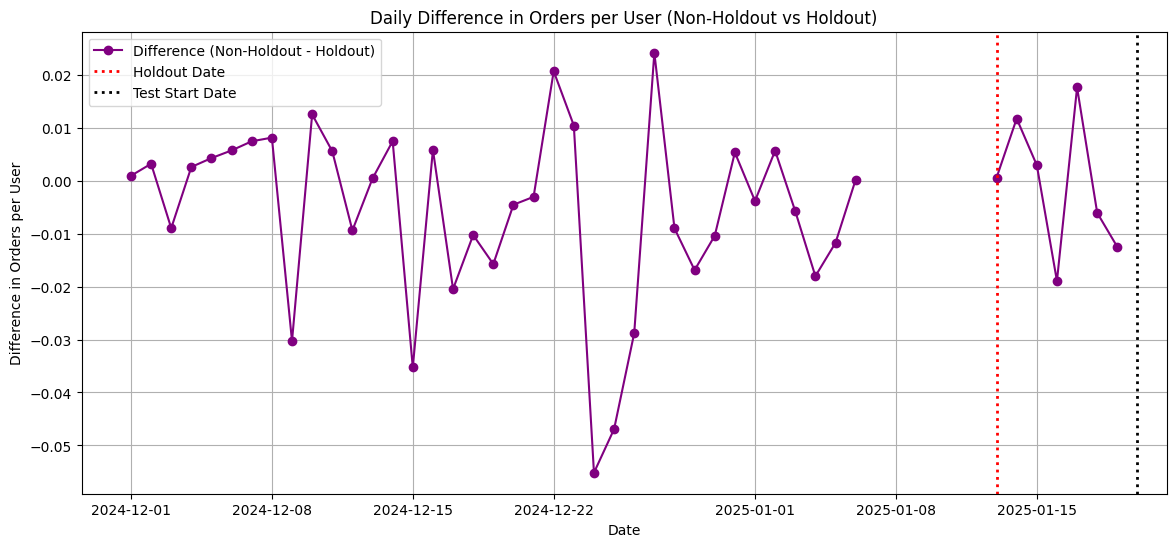

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


df = order_df.copy()

df['created_date'] = pd.to_datetime(df['created_date'])

# Option 1: Pass the date as a string
df = df[df['created_date'] < pd.to_datetime('2025-01-20')]

# Step 1: Calculate Daily Orders per User
daily_orders = df.groupby(['created_date', 'is_customer_holdout']).agg(
    total_orders=('orders', 'sum'),
    unique_users=('dps_customer_id', pd.Series.nunique)
).reset_index()

daily_orders['Orders_per_User'] = daily_orders['total_orders'] / daily_orders['unique_users']

# Pivot the Data to Compare Holdout vs Non-Holdout
pivot_df = daily_orders.pivot(index='created_date', columns='is_customer_holdout', values='Orders_per_User')

# Rename columns for clarity
pivot_df.columns = ['Non_Holdout', 'Holdout'] if False in pivot_df.columns else ['Holdout', 'Non_Holdout']

# Calculate the Difference: Non-Holdout - Holdout
pivot_df['Difference'] = pivot_df['Non_Holdout'] - pivot_df['Holdout']

# Plotting the Difference Over Time
plt.figure(figsize=(14, 6))
plt.plot(pivot_df.index, pivot_df['Difference'], color='purple', linestyle='-', marker='o', label='Difference (Non-Holdout - Holdout)')

# Mark Holdout and Test Start Dates
plt.axvline(x=pd.to_datetime('2025-01-13'), color='red', linestyle=':', linewidth=2, label='Holdout Date')
plt.axvline(x=pd.to_datetime('2025-01-20'), color='black', linestyle=':', linewidth=2, label='Test Start Date')

plt.xlabel('Date')
plt.ylabel('Difference in Orders per User')
plt.title('Daily Difference in Orders per User (Non-Holdout vs Holdout)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from scipy.stats import ttest_ind

# Separate Orders per User for Holdout and Non-Holdout
holdout_orders = daily_orders[daily_orders['is_customer_holdout'] == True]['Orders_per_User']
non_holdout_orders = daily_orders[daily_orders['is_customer_holdout'] == False]['Orders_per_User']

# Perform T-Test
t_stat, p_value = ttest_ind(non_holdout_orders, holdout_orders, equal_var=False)

print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

T-Statistic: -1.103481688570035
P-Value: 0.27372973503982156


In [ ]:
df.columns

Index(['entity_id', 'created_date', 'is_customer_holdout', 'dps_customer_id',
       'is_in_campaign', 'campaign_type', 'campaign_id', 'is_in_test',
       'basic_assignment_type', 'basic_assignment_id', 'has_dps_incentive',
       'dps_incentive_assignment_type', 'orders', 'orders_with_incentive',
       'gfv_eur', 'dps_delivery_fee', 'dps_incentive_discount',
       'dps_standard_fee', 'delivery_costs', 'discount_dh_eur', 'flgp',
       'profit_eur', 'revenue_eur', 'period'],
      dtype='object')

In [597]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load and prepare data
df = order_df.copy()

df = df[df['variant'] == False]

df['created_date'] = pd.to_datetime(df['created_date'])

# Define holdout release date
holdout_release_date = pd.to_datetime('2025-01-13')

# Add a column to mark pre- and post-holdout periods
df['period'] = df['created_date'].apply(lambda x: 'pre' if x < holdout_release_date else 'post')

# Step 1: Calculate Daily Orders per User
daily_orders = df.groupby(['created_date', 'is_customer_holdout']).agg(
    total_orders=('orders', 'sum'),
    unique_users=('dps_customer_id', pd.Series.nunique)
).reset_index()

daily_orders['Orders_per_User'] = daily_orders['total_orders'] / daily_orders['unique_users']

# Merge period information into daily_orders
daily_orders = pd.merge(daily_orders, df[['created_date', 'period']].drop_duplicates(), on='created_date')

# Convert Boolean to Integer for Regression Compatibility
daily_orders['is_customer_holdout'] = daily_orders['is_customer_holdout'].astype(int)

# Create a post-period indicator (1 if post holdout release, else 0)
daily_orders['post_period'] = (daily_orders['created_date'] >= holdout_release_date).astype(int)

# Step 2: Run Difference-in-Differences Regression
model = smf.ols('Orders_per_User ~ is_customer_holdout * post_period', data=daily_orders).fit()

# Display Regression Results
print(model.summary())

# Step 3: Run T-Tests for Holdout and Non-Holdout Groups
# Separate Holdout and Non-Holdout data
holdout_data = daily_orders[daily_orders['is_customer_holdout'] == 1]
non_holdout_data = daily_orders[daily_orders['is_customer_holdout'] == 0]

# T-Test for Holdout Group (Pre vs Post)
pre_holdout_orders = holdout_data[holdout_data['period'] == 'pre']['Orders_per_User']
post_holdout_orders = holdout_data[holdout_data['period'] == 'post']['Orders_per_User']
t_stat_holdout, p_value_holdout = ttest_ind(pre_holdout_orders, post_holdout_orders, equal_var=False)

# T-Test for Non-Holdout Group (Pre vs Post)
pre_non_holdout_orders = non_holdout_data[non_holdout_data['period'] == 'pre']['Orders_per_User']
post_non_holdout_orders = non_holdout_data[non_holdout_data['period'] == 'post']['Orders_per_User']
t_stat_non_holdout, p_value_non_holdout = ttest_ind(pre_non_holdout_orders, post_non_holdout_orders, equal_var=False)

# Display T-Test Results
print(f"Holdout Group - T-Statistic: {t_stat_holdout}, P-Value: {p_value_holdout}")
print(f"Non-Holdout Group - T-Statistic: {t_stat_non_holdout}, P-Value: {p_value_non_holdout}")

# Step 4: Plotting Orders per User Over Time
plt.figure(figsize=(14, 6))

# Plot Holdout and Non-Holdout Orders per User
for group in daily_orders['is_customer_holdout'].unique():
    subset = daily_orders[daily_orders['is_customer_holdout'] == group]
    label = 'Holdout' if group == 1 else 'Non-Holdout'
    plt.plot(subset['created_date'], subset['Orders_per_User'], label=label, linestyle='--' if group == 1 else '-')

# Mark Holdout Release Date
plt.axvline(x=holdout_release_date, color='red', linestyle=':', linewidth=2, label='Holdout Release Date')

plt.xlabel('Date')
plt.ylabel('Orders per User')
plt.title('Orders per User Before and After Holdout Release')
plt.legend()
plt.grid(True)
plt.show()


KeyError: 'variant'

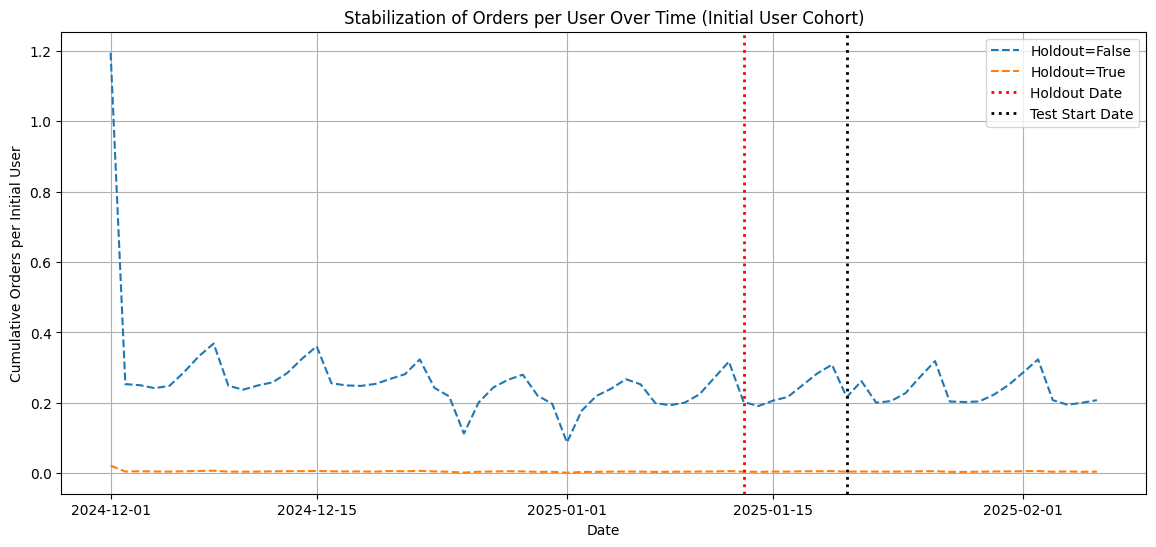

In [561]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is already loaded and 'created_date' is in datetime format
df = order_df.copy()
df['created_date'] = pd.to_datetime(df['created_date'])

# Sort for cumulative calculations
df = df.sort_values(by=['is_customer_holdout', 'created_date'])

# Step 1: Define the first set of users (initial cohort)
first_date = df['created_date'].min()
initial_users = df[df['created_date'] == first_date]['dps_customer_id'].unique()

# Step 2: Track orders from initial cohort over time
df['is_initial_user'] = df['dps_customer_id'].isin(initial_users)

# Cumulative Orders for Initial Cohort
cumulative_initial_orders = df[df['is_initial_user']].groupby(['created_date', 'is_customer_holdout']).agg(
    Cumulative_Orders=('orders', 'sum'),
    Unique_Users=('dps_customer_id', pd.Series.nunique)
).reset_index()

# Step 3: Calculate Cumulative Orders per Initial User
initial_user_count = len(initial_users)
cumulative_initial_orders['Cumulative_Orders_per_User'] = cumulative_initial_orders['Cumulative_Orders'] / initial_user_count

# Step 4: Plotting the Stabilization of Orders per User
plt.figure(figsize=(14, 6))

for group in cumulative_initial_orders['is_customer_holdout'].unique():
    subset = cumulative_initial_orders[cumulative_initial_orders['is_customer_holdout'] == group]
    plt.plot(subset['created_date'], subset['Cumulative_Orders_per_User'], label=f'Holdout={group}', linestyle='--')

# Add Holdout and Test Dates
plt.axvline(x=pd.to_datetime('2025-01-13'), color='red', linestyle=':', linewidth=2, label='Holdout Date')
plt.axvline(x=pd.to_datetime('2025-01-20'), color='black', linestyle=':', linewidth=2, label='Test Start Date')

plt.xlabel('Date')
plt.ylabel('Cumulative Orders per Initial User')
plt.title('Stabilization of Orders per User Over Time (Initial User Cohort)')
plt.legend()
plt.grid(True)
plt.show()


In [558]:
# import numpy as np
# import pandas as pd
# from sklearn.preprocessing import StandardScaler
# from sklearn.cluster import KMeans

# # Convert 'date' column to datetime
# woowa_df['created_date_local'] = pd.to_datetime(woowa_df['created_date_local'])

# # Group by 'zone_id' and aggregate the required metrics
# zone_df = woowa_df.groupby('zone_id').agg(
#     delivery_distance_actual_m=('delivery_distance_actual_m', 'mean'),
#     straight_line_distance_m=('delivery_distance_m', 'mean'),
#     total_orders=('platform_order_code', 'nunique'),
#     min_date=('created_date_local', 'min'),
#     max_date=('created_date_local', 'max'),
#     marketing_classification= ('regional_classification_id', 'max')
# ).reset_index()

# # Calculate the difference in months between min and max date for each 'zone_id'
# zone_df['total_months'] = ((zone_df['max_date'].dt.year - zone_df['min_date'].dt.year) * 12 +
#                      (zone_df['max_date'].dt.month - zone_df['min_date'].dt.month) +
#                      ((zone_df['max_date'].dt.day - zone_df['min_date'].dt.day) > 0).astype(int))

# # calculate the monthly orders for each zone
# zone_df['monthly_orders'] = zone_df['total_orders'] / zone_df['total_months']

# # 1. Log transformation for `total_orders` and 'monthly_orders'
# zone_df['log_monthly_orders'] = np.log1p(zone_df['monthly_orders'])  # log(1 + x) to handle zeros
# zone_df['log_total_orders'] = np.log1p(zone_df['total_orders'])  # log(1 + x) to handle zeros
# zone_df['log_delivery_distance_actual_m'] = np.log1p(zone_df['delivery_distance_actual_m'])  # log(1 + x) to handle zeros
# zone_df['log_straight_line_distance_m'] = np.log1p(zone_df['straight_line_distance_m'])  # log(1 + x) to handle zeros

# # # 2. Z-score scaling for the distance features
# # scaler = StandardScaler()
# # zone_df[['z_delivery_distance_actual_m', 'z_straight_line_distance_m']] = scaler.fit_transform(
# #     zone_df[['delivery_distance_actual_m', 'straight_line_distance_m']]
# # )

# # 3. K-Means Clustering
# def apply_kmeans(data, n_clusters, random_state=42):
#     model = KMeans(n_clusters=n_clusters, random_state=random_state)
#     model.fit(data)
#     return model.labels_

# # Apply K-Means for each feature independently
# zone_df['cluster_delivery_distance'] = apply_kmeans(zone_df[['log_delivery_distance_actual_m']], n_clusters=3)
# zone_df['cluster_straight_line_distance'] = apply_kmeans(zone_df[['log_straight_line_distance_m']], n_clusters=3)
# zone_df['cluster_log_monthly_orders'] = apply_kmeans(zone_df[['log_monthly_orders']], n_clusters=3)
# zone_df['cluster_log_total_orders'] = apply_kmeans(zone_df[['log_total_orders']], n_clusters=3)
# zone_df['cluster_log_order_straight_d'] = apply_kmeans(zone_df[['log_total_orders','log_straight_line_distance_m']], n_clusters=4)

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_50013/2235988098.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cumulative_discounts = daily_discounts.groupby('is_customer_holdout').apply(


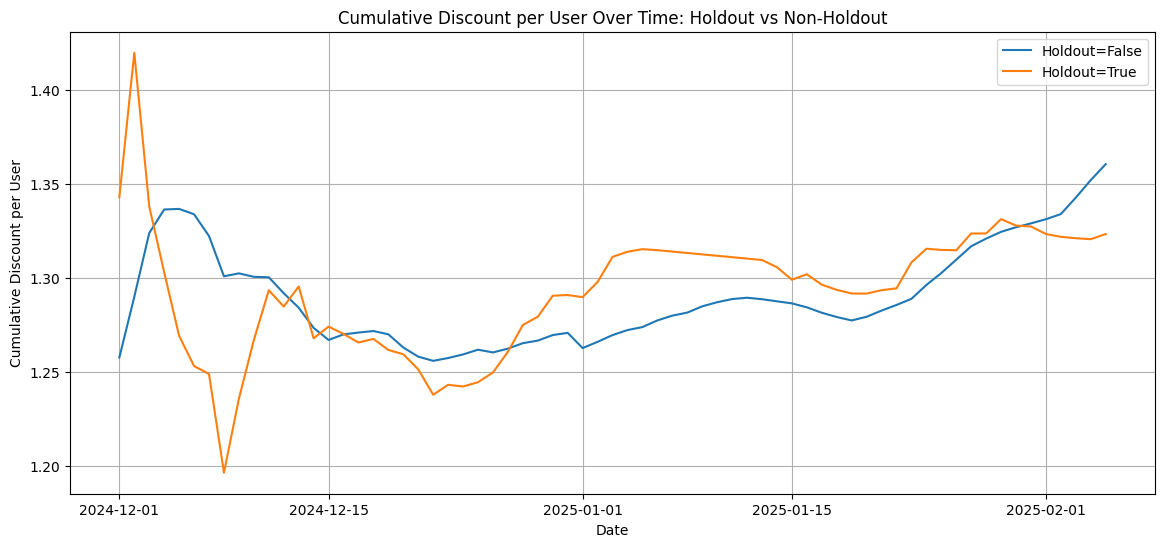

In [537]:
# Calculate daily total discounts and unique users
daily_discounts = df.groupby(['created_date', 'is_customer_holdout']).agg(
    total_discount=('discount_dh_eur', 'sum'),
    unique_users=('dps_customer_id', pd.Series.nunique)
).reset_index()

# Sort data to ensure proper cumulative calculation
daily_discounts = daily_discounts.sort_values(by='created_date')

# Calculate cumulative total discounts and cumulative unique users
cumulative_discounts = daily_discounts.groupby('is_customer_holdout').apply(
    lambda x: x.assign(
        Cumulative_Discount=x['total_discount'].cumsum(),
        Cumulative_Unique_Users=x['unique_users'].cumsum()
    )
).reset_index(drop=True)

# Calculate cumulative average discount per user
cumulative_discounts['Cumulative_Discount_per_User'] = cumulative_discounts['Cumulative_Discount'] / cumulative_discounts['Cumulative_Unique_Users']

# Plotting cumulative average discount per user
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

for group in cumulative_discounts['is_customer_holdout'].unique():
    subset = cumulative_discounts[cumulative_discounts['is_customer_holdout'] == group]
    plt.plot(subset['created_date'], subset['Cumulative_Discount_per_User'], label=f'Holdout={group}')

plt.xlabel('Date')
plt.ylabel('Cumulative Discount per User')
plt.title('Cumulative Discount per User Over Time: Holdout vs Non-Holdout')
plt.legend()
plt.grid(True)
plt.show()


In [536]:
# Calculate cumulative discounts
cumulative_discounts = df.groupby(['created_date', 'is_customer_holdout']).agg(
    total_discount=('discount_dh_eur', 'sum')
).groupby('is_customer_holdout').cumsum().reset_index()

# Plotting cumulative discounts
plt.figure(figsize=(14, 6))

for group in cumulative_discounts['is_customer_holdout'].unique():
    subset = cumulative_discounts[cumulative_discounts['is_customer_holdout'] == group]
    plt.plot(subset['created_date'], subset['total_discount'], label=f'Holdout={group}')

plt.xlabel('Date')
plt.ylabel('Cumulative Discounts')
plt.title('Cumulative Discounts Over Time: Holdout vs Non-Holdout')
plt.legend()
plt.grid(True)
plt.show()

NotImplementedError: function is not implemented for this dtype: [how->cumsum,dtype->object]

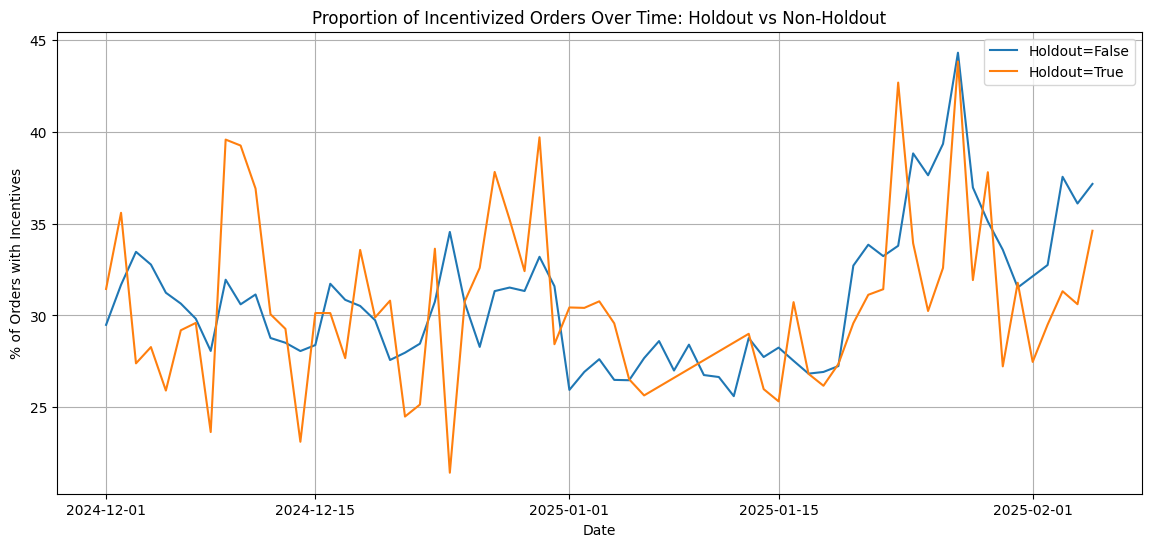

In [535]:
# Calculate total orders and incentivized orders per group
incentive_analysis = df.groupby(['created_date', 'is_customer_holdout']).agg(
    total_orders=('orders', 'sum'),
    incentivized_orders=('orders_with_incentive', 'sum')
).reset_index()

# Calculate percentage of orders with incentives
incentive_analysis['pct_incentivized_orders'] = (incentive_analysis['incentivized_orders'] / 
                                                 incentive_analysis['total_orders']) * 100

# Plotting
plt.figure(figsize=(14, 6))

for group in incentive_analysis['is_customer_holdout'].unique():
    subset = incentive_analysis[incentive_analysis['is_customer_holdout'] == group]
    plt.plot(subset['created_date'], subset['pct_incentivized_orders'], label=f'Holdout={group}')

plt.xlabel('Date')
plt.ylabel('% of Orders with Incentives')
plt.title('Proportion of Incentivized Orders Over Time: Holdout vs Non-Holdout')
plt.legend()
plt.grid(True)
plt.show()


In [511]:
daily_orders_per_user

,created_date,is_customer_holdout,Orders_per_User
0,2024-12-01,False,1.021982
1,2024-12-01,True,1.021053
2,2024-12-02,False,1.020437
3,2024-12-02,True,1.017241
4,2024-12-03,False,1.017183
...,...,...,...
123,2025-02-03,True,1.005525
124,2025-02-04,False,1.026866
125,2025-02-04,True,1.013793
126,2025-02-05,False,1.027192


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_50013/2819829301.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cumulative_orders = daily_orders.groupby('is_customer_holdout').apply(


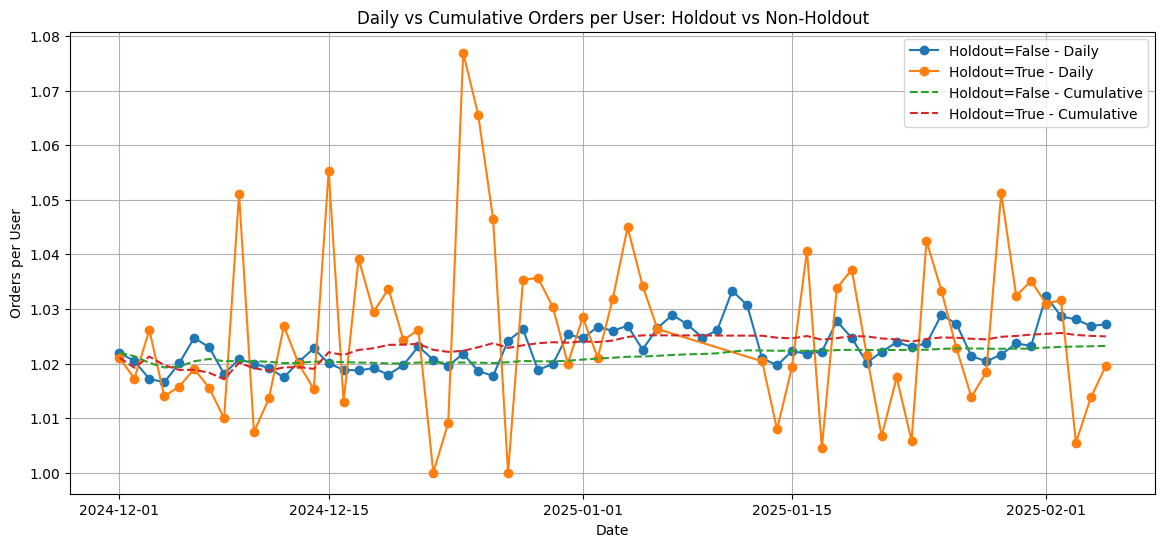

In [514]:
import pandas as pd
import matplotlib.pyplot as plt

# Copy original dataframe and ensure date is in datetime format
df = order_df.copy()
df['created_date'] = pd.to_datetime(df['created_date'])

# Step 1: Calculate Daily Orders per User
daily_orders = df.groupby(['created_date', 'is_customer_holdout']).agg(
    total_orders=('orders', 'sum'),
    unique_users=('dps_customer_id', pd.Series.nunique)
).reset_index()

# Calculate Daily Orders per User
daily_orders['Orders_per_User'] = daily_orders['total_orders'] / daily_orders['unique_users']

# Step 2: Calculate Cumulative Orders per User (Separate DataFrame)
# Sort data to ensure proper cumulative calculation
daily_orders = daily_orders.sort_values(by='created_date')

# Calculate cumulative orders and cumulative unique users separately
cumulative_orders = daily_orders.groupby('is_customer_holdout').apply(
    lambda x: x.assign(
        Cumulative_Orders=x['total_orders'].cumsum(),
        Cumulative_Unique_Users=x['unique_users'].cumsum(),
        Cumulative_Orders_per_User=lambda y: y['Cumulative_Orders'] / y['Cumulative_Unique_Users']
    )
).reset_index(drop=True)

# Step 3: Plotting the Data
plt.figure(figsize=(14, 6))

# Plot Daily Orders per User
for group in daily_orders['is_customer_holdout'].unique():
    subset_daily = daily_orders[daily_orders['is_customer_holdout'] == group]
    plt.plot(subset_daily['created_date'], subset_daily['Orders_per_User'], label=f'Holdout={group} - Daily', marker='o')

# Plot Cumulative Orders per User
for group in cumulative_orders['is_customer_holdout'].unique():
    subset_cum = cumulative_orders[cumulative_orders['is_customer_holdout'] == group]
    plt.plot(subset_cum['created_date'], subset_cum['Cumulative_Orders_per_User'], label=f'Holdout={group} - Cumulative', linestyle='--')

# Customize plot
plt.xlabel('Date')
plt.ylabel('Orders per User')
plt.title('Daily vs Cumulative Orders per User: Holdout vs Non-Holdout')
plt.legend()
plt.grid(True)
plt.show()


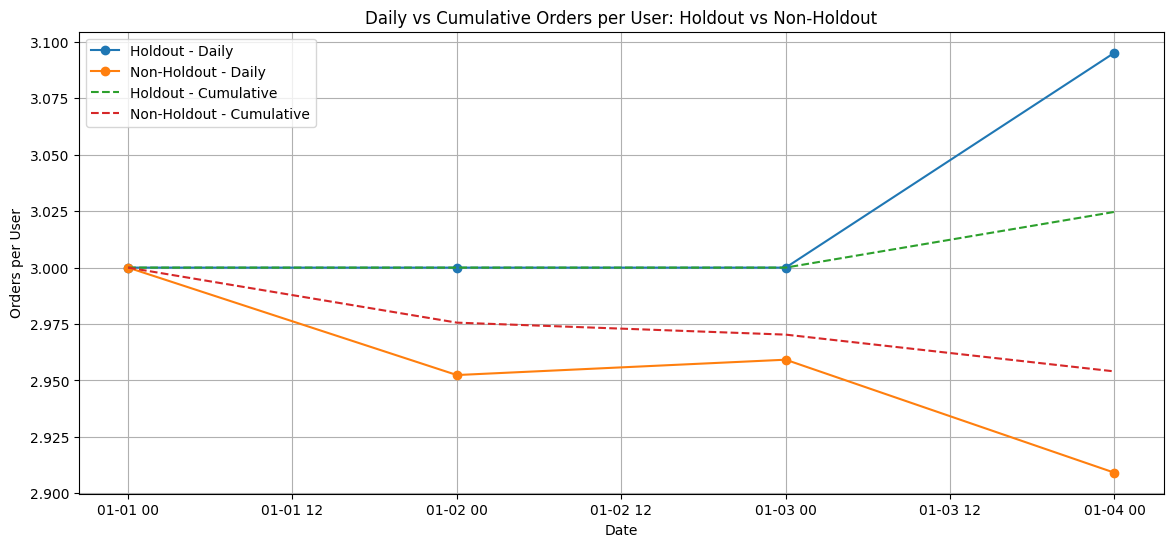

In [503]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
data = {
    'Date': ['2025-01-01', '2025-01-01', '2025-01-02', '2025-01-02', 
             '2025-01-03', '2025-01-03', '2025-01-04', '2025-01-04'],
    'Group': ['Holdout', 'Non-Holdout', 'Holdout', 'Non-Holdout',
              'Holdout', 'Non-Holdout', 'Holdout', 'Non-Holdout'],
    'Orders': [120, 300, 150, 310, 90, 290, 130, 320],
    'Users': [40, 100, 50, 105, 30, 98, 42, 110]
}

df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'])

# Calculate daily Orders per User
df['Orders_per_User'] = df['Orders'] / df['Users']

# Calculate cumulative Orders and Users
df['Cumulative_Orders'] = df.groupby('Group')['Orders'].cumsum()
df['Cumulative_Users'] = df.groupby('Group')['Users'].cumsum()

# Calculate cumulative Orders per User
df['Cumulative_Orders_per_User'] = df['Cumulative_Orders'] / df['Cumulative_Users']

# Plotting Daily Orders per User
plt.figure(figsize=(14, 6))
for group in df['Group'].unique():
    subset = df[df['Group'] == group]
    plt.plot(subset['Date'], subset['Orders_per_User'], label=f'{group} - Daily', marker='o')

# Plotting Cumulative Orders per User
for group in df['Group'].unique():
    subset = df[df['Group'] == group]
    plt.plot(subset['Date'], subset['Cumulative_Orders_per_User'], label=f'{group} - Cumulative', linestyle='--')

# Customize plot
plt.xlabel('Date')
plt.ylabel('Orders per User')
plt.title('Daily vs Cumulative Orders per User: Holdout vs Non-Holdout')
plt.legend()
plt.grid(True)
plt.show()

In [492]:
order_df.columns

Index(['entity_id', 'release_date', 'created_date', 'is_customer_holdout',
       'dps_customer_id', 'is_in_campaign', 'campaign_type', 'campaign_id',
       'is_in_test', 'basic_assignment_type', 'basic_assignment_id',
       'has_dps_incentive', 'dps_incentive_assignment_type', 'orders',
       'orders_with_incentive', 'gfv_eur', 'dps_delivery_fee',
       'dps_incentive_discount', 'dps_standard_fee', 'delivery_costs',
       'discount_dh_eur', 'flgp', 'profit_eur', 'revenue_eur'],
      dtype='object')

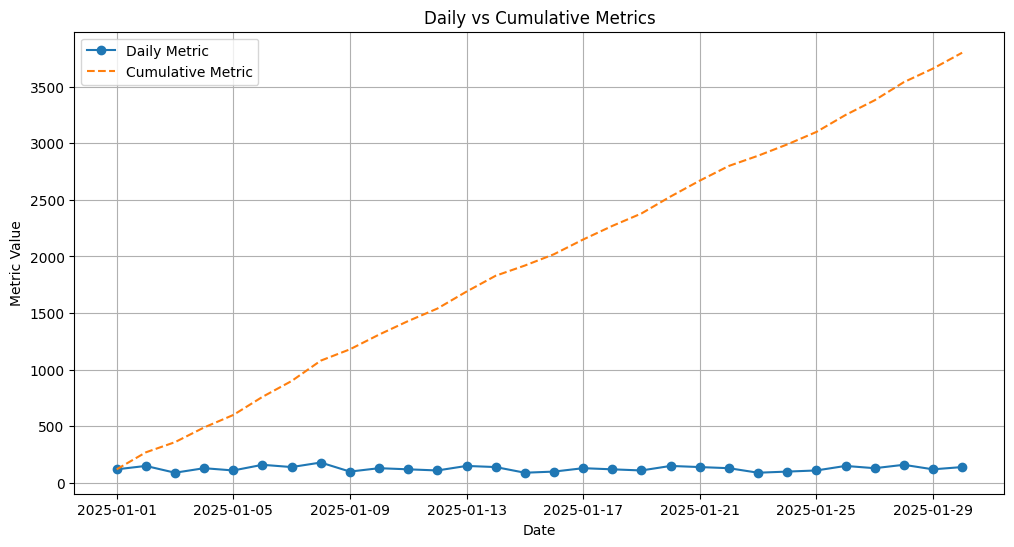

In [500]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample data
data = {
    'Date': pd.date_range(start='2025-01-01', periods=30, freq='D'),
    'Metric_Value': [120, 150, 90, 130, 110, 160, 140, 180, 100, 130,
                     120, 110, 150, 140, 90, 100, 130, 120, 110, 150,
                     140, 130, 90, 100, 110, 150, 130, 160, 120, 140]
}

df = pd.DataFrame(data)

# Calculate cumulative metrics
df['Cumulative_Metric'] = df['Metric_Value'].cumsum()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Metric_Value'], label='Daily Metric', marker='o')
plt.plot(df['Date'], df['Cumulative_Metric'], label='Cumulative Metric', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Metric Value')
plt.title('Daily vs Cumulative Metrics')
plt.legend()
plt.grid(True)
plt.show()

In [502]:
a['cumulative_customers'] = a['dps_customer_id'].cumsum()
a['cumulative_orders'] = a['orders'].cumsum()

a

,entity_id,created_date,is_customer_holdout,dps_customer_id,orders,opu,cumulative_customers,cumulative_orders
0,PO_FI,2024-12-01,False,6281,6438,1.024996,6281,6438
1,PO_FI,2024-12-01,True,88,89,1.011364,6369,6527
2,PO_FI,2024-12-02,False,4256,4353,1.022791,10625,10880
3,PO_FI,2024-12-02,True,77,79,1.025974,10702,10959
4,PO_FI,2024-12-03,False,4251,4334,1.019525,14953,15293
...,...,...,...,...,...,...,...,...
118,PO_FI,2025-02-02,False,1,1,1.0,452800,463139
119,PO_FI,2025-02-02,True,244,251,1.028689,453044,463390
120,PO_FI,2025-02-03,True,178,179,1.005618,453222,463569
121,PO_FI,2025-02-04,True,141,143,1.014184,453363,463712


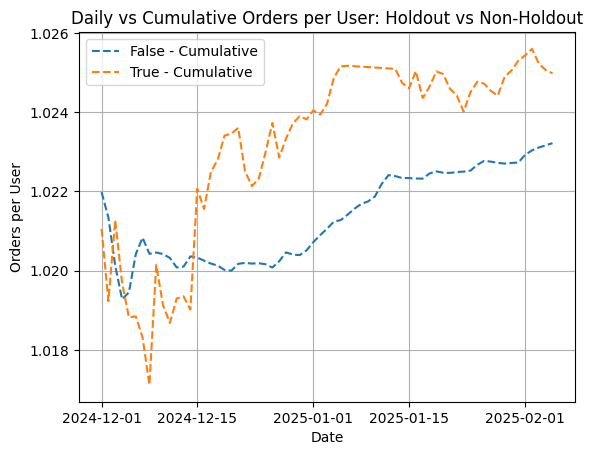

In [507]:
tmp = order_df[(order_df['is_in_campaign'] == False) & (order_df['is_in_test'] == False)]

a = order_df.groupby(['entity_id','created_date','is_customer_holdout']).agg({'dps_customer_id':'nunique','orders':'sum'}).reset_index()

a['opu'] = a['orders'] / a['dps_customer_id']

# Calculate cumulative Orders and Users
a['Cumulative_Orders'] = a.groupby('is_customer_holdout')['orders'].cumsum()
a['Cumulative_Users'] = a.groupby('is_customer_holdout')['dps_customer_id'].cumsum()

a['Cumulative_Orders_per_User'] = a['Cumulative_Orders'] / a['Cumulative_Users']

# # Plotting Daily Orders per User
# plt.figure(figsize=(14, 6))
# for group in a['is_customer_holdout'].unique():
#     subset = a[a['is_customer_holdout'] == group]
#     plt.plot(subset['created_date'], subset['opu'], label=f'{group} - Daily', marker='o')

# Plotting Cumulative Orders per User
for group in a['is_customer_holdout'].unique():
    subset = a[a['is_customer_holdout'] == group]
    plt.plot(subset['created_date'], subset['Cumulative_Orders_per_User'], label=f'{group} - Cumulative', linestyle='--')

# Customize plot
plt.xlabel('Date')
plt.ylabel('Orders per User')
plt.title('Daily vs Cumulative Orders per User: Holdout vs Non-Holdout')
plt.legend()
plt.grid(True)
plt.show()


In [482]:
order_df.groupby(['entity_id','is_in_campaign']).agg({'orders':'sum','customers':'sum'})


orders  customers
entity_id is_in_campaign                   
PO_FI     False           642688     633675
          True             43721      43614

In [481]:
order_df.groupby(['entity_id','created_date','is_customer_holdout']).agg({'orders':'sum','customers':'sum'})

,entity_id,release_date,created_date,is_customer_holdout,is_in_campaign,campaign_type,campaign_id,is_in_test,basic_assignment_type,basic_assignment_id,...,orders_with_incentive,gfv_eur,dps_delivery_fee,dps_incentive_discount,dps_standard_fee,delivery_costs,discount_dh_eur,flgp,profit_eur,revenue_eur
0,PO_FI,2025-01-13,2024-12-22,False,False,None,None,False,Automatic scheme,629.000000000,...,484,11569.000000000,25.220000000,-2170.620000000,2195.840000000,3033.705326,2170.620000000,-4512.414098,-1535.404098,1498.301228
1,PO_FI,2025-01-13,2024-12-22,True,False,None,None,False,Automatic scheme,629.000000000,...,8,271.650000000,1.370000000,-37.530000000,38.900000000,47.713636,37.530000000,-61.115040,-9.585040,38.128596
2,PO_FI,2025-01-13,2024-12-22,False,True,Campaign Override,586.000000000,False,Automatic scheme,626.000000000,...,44,1476.050000000,0E-9,-140.060000000,140.060000000,235.783997,140.060000000,-234.652944,-62.952944,172.831053
3,PO_FI,2025-01-13,2024-12-22,False,True,Campaign Override,619.000000000,False,Automatic scheme,628.000000000,...,4,78.700000000,0E-9,-15.960000000,15.960000000,20.431458,15.960000000,-14.586546,6.373454,26.804912
4,PO_FI,2025-01-13,2024-12-22,False,True,Campaign Override,647.000000000,False,Automatic scheme,628.000000000,...,8,274.960000000,0E-9,-27.920000000,27.920000000,39.476758,27.920000000,-22.881144,20.038856,59.515614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4395,PO_FI,2025-01-13,2024-12-24,False,True,Campaign Override,622.000000000,False,Automatic scheme,626.000000000,...,0,21.150000000,5.490000000,0E-9,0E-9,9.929498,0E-9,-2.662129,-2.662129,7.267368
4396,PO_FI,2025-01-13,2025-02-04,False,True,Campaign Override,669.000000000,True,Automatic scheme,628.000000000,...,0,20.150000000,3.990000000,0E-9,0E-9,4.760000,0E-9,1.472807,1.472807,6.232807
4397,PO_FI,2025-01-13,2024-12-30,True,True,Campaign Override,615.000000000,False,Automatic scheme,626.000000000,...,1,31.900000000,0E-9,-4.490000000,4.490000000,5.800000,4.490000000,3.573333,8.063333,13.863333
4398,PO_FI,2025-01-13,2024-12-29,False,True,Campaign Override,587.000000000,False,Automatic scheme,628.000000000,...,1,19.600000000,0E-9,-2.990000000,2.990000000,4.876462,2.990000000,-6.051374,-3.061374,1.815088


In [472]:
opu_trend_df = client.query(opu_trend).to_dataframe()

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_50013/747314644.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  opu_t['opu'] = opu_t['orders'] / opu_t['users']


<Axes: xlabel='created_date', ylabel='opu'>

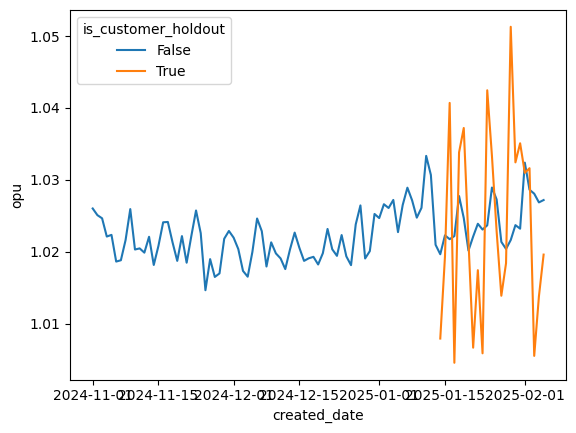

In [476]:
opu_t = opu_trend_df[opu_trend_df['entity_id'] == 'PO_FI']

opu_t['opu'] = opu_t['orders'] / opu_t['users']

sns.lineplot(x='created_date',y='opu', hue='is_customer_holdout', data=opu_t)

In [468]:
opu_df['created_date'].min()

datetime.date(2025, 1, 2)

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_50013/1049630971.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['opu'] = test['orders'] / test['users']


<Axes: xlabel='created_date', ylabel='opu'>

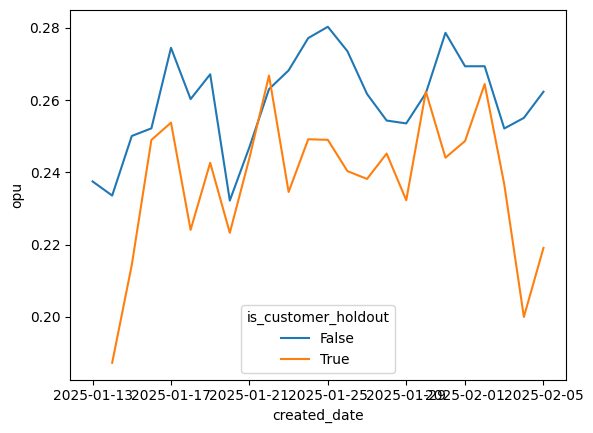

In [463]:
test = opu_df[opu_df['entity_id'] == 'PO_FI']
test['opu'] = test['orders'] / test['users']

# Plotting
sns.lineplot(x='created_date',y='opu', hue='is_customer_holdout', data=test)


















In [456]:
opu_df['release_date'].unique()

<DateArray>
[datetime.date(2025, 1, 14),  datetime.date(2025, 1, 9),
  datetime.date(2025, 1, 7), datetime.date(2025, 1, 15),
  datetime.date(2025, 1, 2),  datetime.date(2025, 1, 8),
 datetime.date(2025, 1, 10),  datetime.date(2025, 1, 6),
 datetime.date(2025, 1, 13)]
Length: 9, dtype: dbdate

In [440]:
user_df.columns

Index(['entity_id', 'release_date', 'dps_customer_id', 'is_after_release',
       'is_customer_holdout', 'is_in_campaign', 'campaign_type', 'campaign_id',
       'is_in_test', 'basic_assignment_type', 'basic_assignment_id',
       'has_dps_incentive', 'dps_incentive_assignment_type', 'orders',
       'orders_with_incentive', 'dps_delivery_fee', 'dps_incentive_discount',
       'dps_standard_fee'],
      dtype='object')

In [441]:
user_df.groupby(['entity_id','is_in_campaign']).agg({'orders':'sum','dps_customer_id':'nunique'})



,,orders,dps_customer_id
entity_id,is_in_campaign,,
GV_UG,False,281867,78391


In [442]:
user_df.groupby(['entity_id','is_in_test']).agg({'orders':'sum','dps_customer_id':'nunique'})

orders  dps_customer_id
entity_id is_in_test                         
GV_UG     False       281213            78256
          True           654              481

In [443]:
user_df[(user_df['is_in_test'] == False) & (user_df['is_in_campaign'] == False)].groupby(['entity_id','basic_assignment_type']).agg({'orders':'sum','dps_customer_id':'nunique'})

orders  dps_customer_id
entity_id basic_assignment_type                         
GV_UG     Automatic scheme       281124            78249
          Country fallback           89               54

In [444]:
user_df[(user_df['is_in_test'] == False) & (user_df['is_in_campaign'] == False) & (user_df['basic_assignment_type'] == 'Automatic scheme')].groupby(['entity_id','is_customer_holdout']).agg({'orders':'sum','dps_customer_id':'nunique'})

orders  dps_customer_id
entity_id is_customer_holdout                         
GV_UG     False                278741            77889
          True                   2383              888

In [445]:
print(278741 / 77889)
print(2383 / 888)

3.5786953228312086
2.6835585585585586


In [451]:
opu_grouped_df['opu'] = opu_grouped_df['orders'] / opu_grouped_df['users'] 
opu_grouped_pivot = opu_grouped_df.pivot_table(index = 'entity_id', columns='is_customer_holdout', values='opu').reset_index()

opu_grouped_pivot['perc_change_nonholdout'] = 100 * abs((opu_grouped_pivot[False] - opu_grouped_pivot[True]) / opu_grouped_pivot[False])

check = opu_grouped_pivot[opu_grouped_pivot['perc_change_nonholdout'] >= 5]

outliers = check['entity_id'].tolist()

check

is_customer_holdout,entity_id,False,True,perc_change_nonholdout
2,EF_GR,1.189537,1.117001,6.0978
13,GV_BA,1.220591,1.110836,8.991936
14,GV_BG,1.252971,1.179716,5.846452
17,GV_KE,0.779841,0.723736,7.194404
25,HS_SA,0.930298,0.321778,65.411299
29,PO_FI,0.640738,0.586445,8.473575
37,PY_HN,1.612385,1.528678,5.191496


In [477]:
8/ 52

0.15384615384615385

 = 8 / 52

glovo experiments (incentive experiments override holdout groups) -> 

incentive experiments ()
check if incentive experiments were running when the holdouts were introduced

overrides not applying to holdout -> hierarchy -> dps document 

read through holdout groups PRD

Bad weather surcharge or MOV effecting anything

dps_delivery_fee vs customer paid delivery -> holdouts and non holdout -> platform over riding to check if platform is reading correctly

MP vendors -> MP vendors a large share in Greece. 

Experiments for orders and 

delivery_fee
Service fee
MOV
Priority fee
Saver fee
Any fees





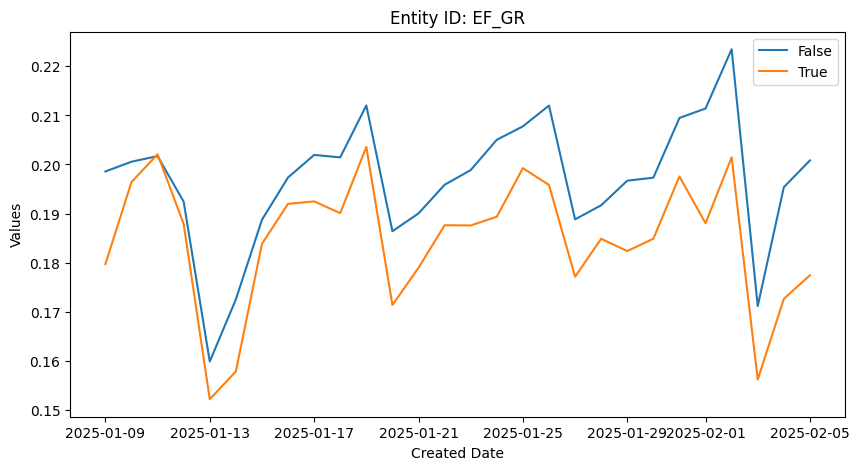

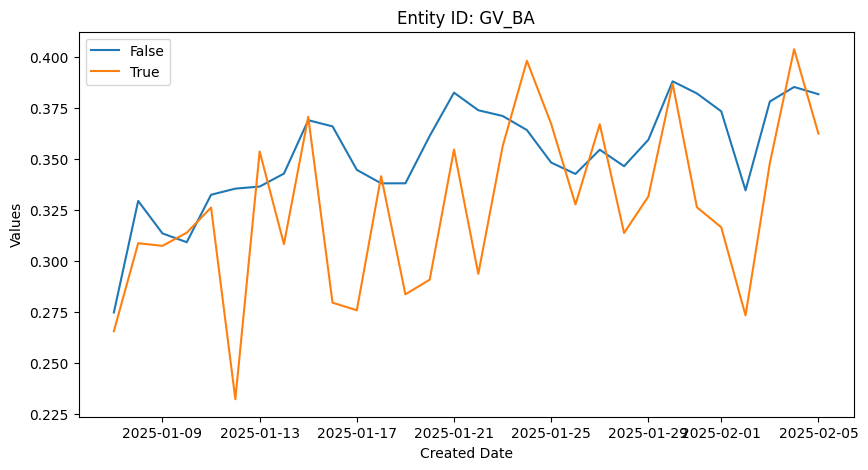

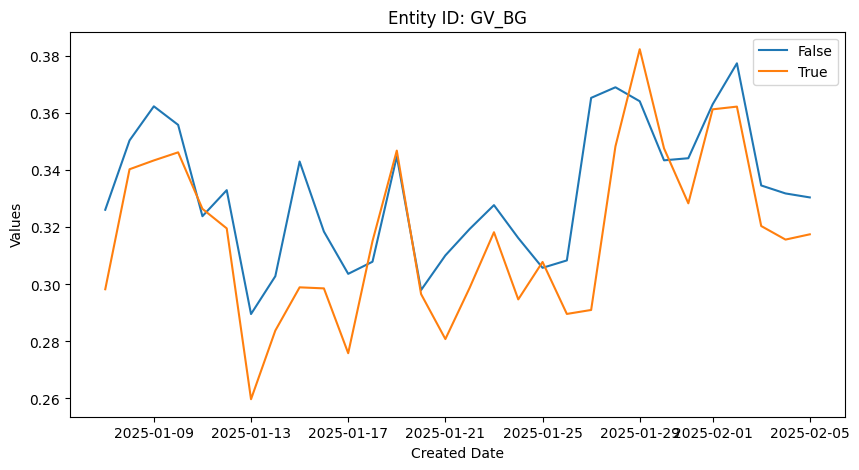

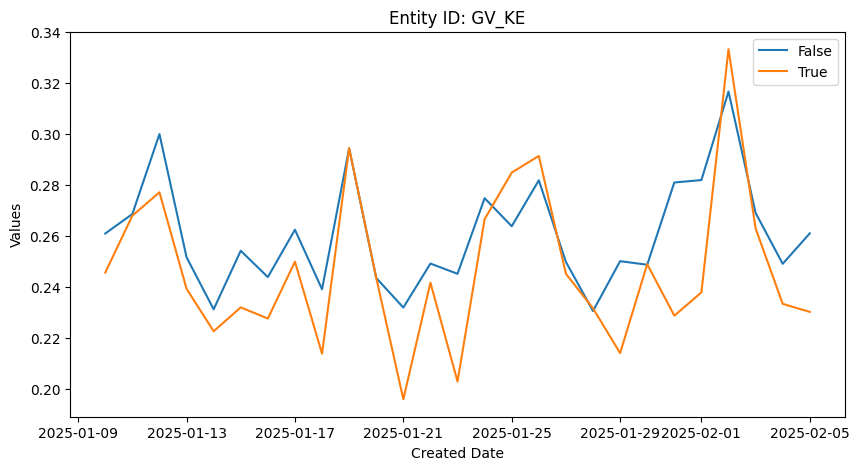

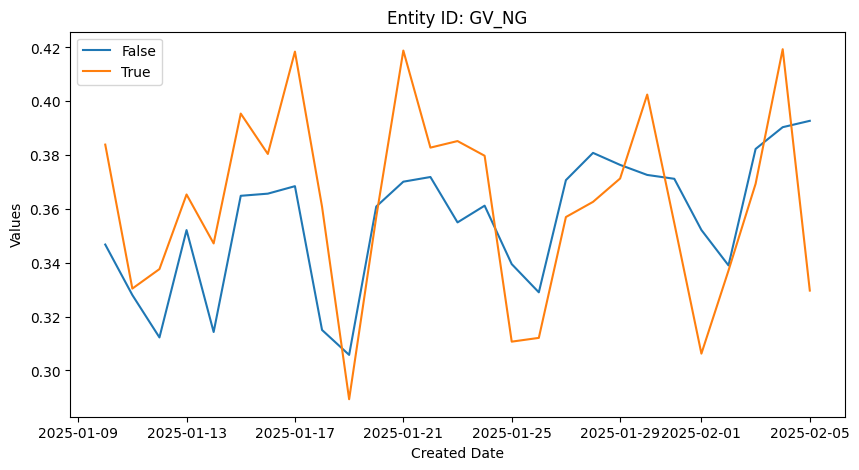

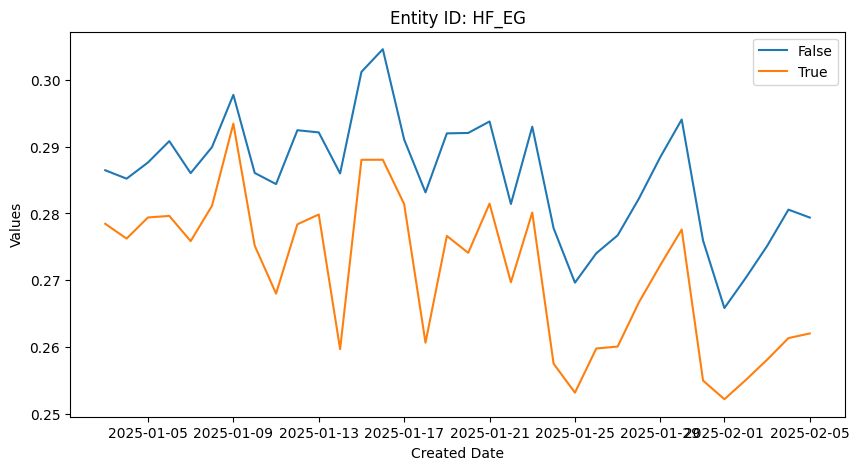

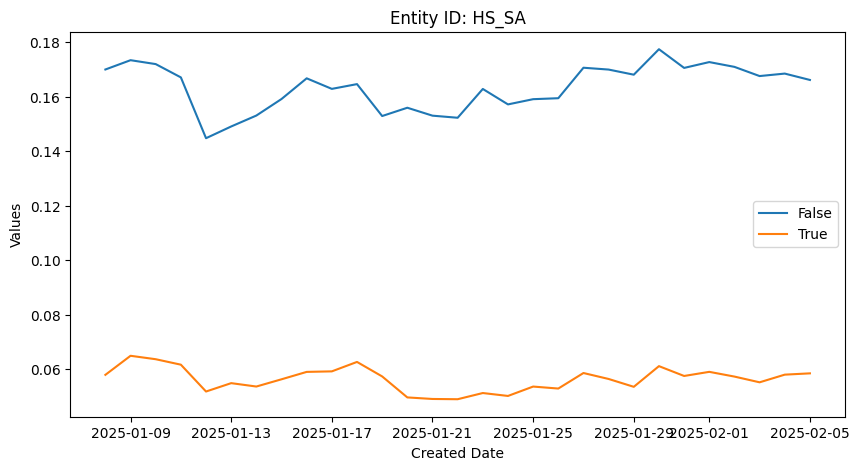

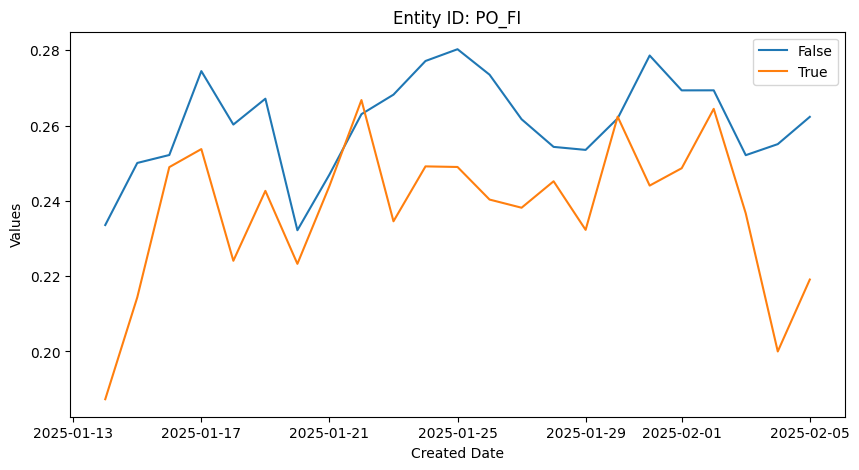

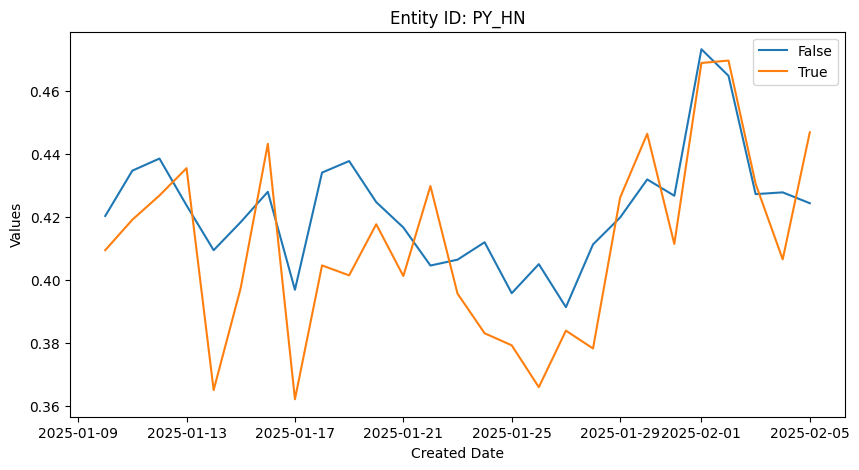

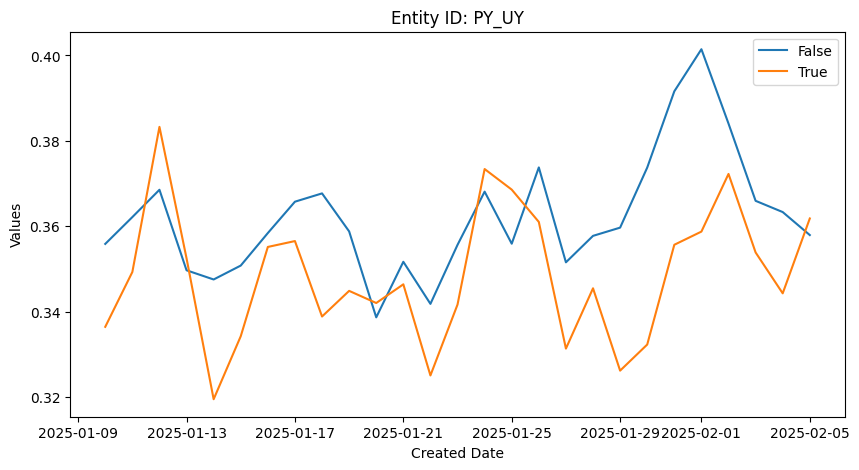

In [450]:
opu_df['created_date'] = pd.to_datetime(opu_df['created_date'])

opu_agg = opu_df[opu_df['entity_id'].isin(outliers)]

tmp = opu_agg.groupby(['entity_id','created_date','is_customer_holdout']).agg({'users':'sum','orders':'sum'}).reset_index()

tmp['orders_per_user'] = tmp['orders'] / tmp['users']

opu_pivot = tmp.pivot_table(index = ['entity_id','created_date'], columns='is_customer_holdout', values='orders_per_user').reset_index()

opu_pivot['perc_change_nonholdout'] = 100 * abs((opu_pivot[False] - opu_pivot[True]) / opu_pivot[False])

opu_pivot

import matplotlib.pyplot as plt

# Loop through each unique entity_id
for e in opu_pivot['entity_id'].unique():
    plt_df = opu_pivot[opu_pivot['entity_id'] == e]
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(plt_df['created_date'], plt_df[False], label='False')
    plt.plot(plt_df['created_date'], plt_df[True], label='True')
    
    # Adding titles and labels
    plt.title(f'Entity ID: {e}')
    plt.xlabel('Created Date')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

In [448]:
GV_BA
FP_MM
GV_KE
PO_FI
FP_BD
TB_BH
TB_KW
GV_NG
HF_EG
EF_GR
FP_PH
FP_TH
GV_BG
HS_SA
PY_HN

NameError: name 'GV_BA' is not defined

In [338]:
mkt_df.columns

Index(['analysis_week', 'global_entity_id', 'release_date',
       'holdout_customers', 'non_holdout_customers', 'all_customers',
       'holdout_orders', 'non_holdout_orders', 'holdout_gmv',
       'non_holdout_gmv', 'holdout_gfv', 'non_holdout_gfv', 'flgp_holdout',
       'flgp_non_holdout', 'holdout_revenue_net', 'non_holdout_revenue_net',
       'holdout_delivery_costs', 'non_holdout_delivery_costs',
       'holdout_delivery_fee_net', 'non_holdout_delivery_fee_net',
       'holdout_dh_funded_basket_incentives',
       'non_holdout_dh_funded_basket_incentives', 'holdout_cost_of_sales',
       'non_holdout_cost_of_sales', 'holdout_cost_of_goods_sold',
       'non_holdout_cost_of_goods_sold', 'holdout_payment_costs',
       'non_holdout_payment_costs', 'holdout_recooks_and_wastage',
       'non_holdout_recooks_and_wastage', 'holdout_refunds_and_compensation',
       'non_holdout_refunds_and_compensation',
       'holdout_semi_variable_delivery_costs',
       'non_holdout_semi_variable

In [1]:
mkt_df['holdout_delivery_fee_per_order'] = mkt_df['holdout_delivery_fee_net'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_delivery_fee_per_order'] = mkt_df['non_holdout_delivery_fee_net'] / mkt_df['non_holdout_orders'] 

mkt_df['holdout_discount_per_order'] = mkt_df['holdout_dh_funded_basket_incentives'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_discount_per_order'] = mkt_df['non_holdout_dh_funded_basket_incentives'] / mkt_df['non_holdout_orders'] 

mkt_df['holdout_revenue_per_order'] = mkt_df['holdout_revenue_net'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_revenue_per_order'] = mkt_df['non_holdout_revenue_net'] / mkt_df['non_holdout_orders'] 

mkt_df['holdout_cos_per_order'] = mkt_df['holdout_cost_of_sales'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_cos_per_order'] = mkt_df['non_holdout_cost_of_sales'] / mkt_df['non_holdout_orders'] 

mkt_df['holdout_delivery_costs_per_order'] = mkt_df['holdout_delivery_costs'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_delivery_costs_per_order'] = mkt_df['non_holdout_delivery_costs'] / mkt_df['non_holdout_orders'] 

mkt_df['holdout_cost_of_goods_sold_per_order'] = mkt_df['holdout_cost_of_goods_sold'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_holdout_cost_of_goods_sold_per_order'] = mkt_df['non_holdout_cost_of_goods_sold'] / mkt_df['non_holdout_orders'] 

mkt_df['holdout_payment_costs_per_order'] = mkt_df['holdout_payment_costs'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_payment_costs_per_order'] = mkt_df['non_holdout_payment_costs'] / mkt_df['non_holdout_orders']

mkt_df['holdout_recooks_and_wastage_per_order'] = mkt_df['holdout_recooks_and_wastage'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_recooks_and_wastage_per_order'] = mkt_df['non_holdout_recooks_and_wastage'] / mkt_df['non_holdout_orders']

mkt_df['holdout_refunds_and_compensation_per_order'] = mkt_df['holdout_refunds_and_compensation'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_refunds_and_compensation_per_order'] = mkt_df['non_holdout_refunds_and_compensation'] / mkt_df['non_holdout_orders']

mkt_df['holdout_semi_variable_delivery_costs_per_order'] = mkt_df['holdout_semi_variable_delivery_costs'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_semi_variable_delivery_costs_per_order'] = mkt_df['non_holdout_semi_variable_delivery_costs'] / mkt_df['non_holdout_orders']

mkt_df['holdout_contact_center_costs_per_order'] = mkt_df['holdout_contact_center_costs'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_contact_center_costs_per_order'] = mkt_df['non_holdout_contact_center_costs'] / mkt_df['non_holdout_orders']

mkt_df['holdout_other_non_specific_delivery_costs_per_order'] = mkt_df['holdout_other_non_specific_delivery_costs'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_other_non_specific_delivery_costs_per_order'] = mkt_df['non_holdout_other_non_specific_delivery_costs'] / mkt_df['non_holdout_orders']

mkt_df['holdout_commission_fee_net_per_order'] = mkt_df['holdout_commission_fee_net'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_commission_fee_net_per_order'] = mkt_df['non_holdout_commission_fee_net'] / mkt_df['non_holdout_orders']

mkt_df['holdout_sale_of_goods_revenue_net_per_order'] = mkt_df['holdout_sale_of_goods_revenue_net'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_sale_of_goods_revenue_net_per_order'] = mkt_df['non_holdout_sale_of_goods_revenue_net'] / mkt_df['non_holdout_orders']

mkt_df['holdout_card_fee_net_per_order'] = mkt_df['holdout_card_fee_net'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_card_fee_net_per_order'] = mkt_df['non_holdout_card_fee_net'] / mkt_df['non_holdout_orders']

mkt_df['holdout_priority_fee_net_per_order'] = mkt_df['holdout_priority_fee_net'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_priority_fee_net_per_order'] = mkt_df['non_holdout_priority_fee_net'] / mkt_df['non_holdout_orders']

mkt_df['holdout_bad_weather_fee_net_per_order'] = mkt_df['holdout_bad_weather_fee_net'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_bad_weather_fee_net_per_order'] = mkt_df['non_holdout_bad_weather_fee_net'] / mkt_df['non_holdout_orders']

mkt_df['holdout_vendor_funded_delivery_fee_subsidy_net_per_order'] = mkt_df['holdout_vendor_funded_delivery_fee_subsidy_net'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_vendor_funded_delivery_fee_subsidy_net_per_order'] = mkt_df['non_holdout_vendor_funded_delivery_fee_subsidy_net'] / mkt_df['non_holdout_orders']

mkt_df['holdout_service_fee_net_per_order'] = mkt_df['holdout_service_fee_net'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_service_fee_net_per_order'] = mkt_df['non_holdout_service_fee_net'] / mkt_df['non_holdout_orders']

mkt_df['holdout_listing_fee_net_per_order'] = mkt_df['holdout_listing_fee_net'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_listing_fee_net_per_order'] = mkt_df['non_holdout_listing_fee_net'] / mkt_df['non_holdout_orders']

mkt_df['holdout_sublease_revenue_net_per_order'] = mkt_df['holdout_sublease_revenue_net'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_sublease_revenue_net_per_order'] = mkt_df['non_holdout_sublease_revenue_net'] / mkt_df['non_holdout_orders']

mkt_df['holdout_ads_revenue_net_per_order'] = mkt_df['holdout_ads_revenue_net'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_ads_revenue_net_per_order'] = mkt_df['non_holdout_ads_revenue_net'] / mkt_df['non_holdout_orders']

mkt_df['holdout_joker_vendor_fee_net_per_order'] = mkt_df['holdout_joker_vendor_fee_net'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_joker_vendor_fee_net_per_order'] = mkt_df['non_holdout_joker_vendor_fee_net'] / mkt_df['non_holdout_orders']

mkt_df['holdout_other_ncr_net_per_order'] = mkt_df['holdout_other_ncr_net'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_other_ncr_net_per_order'] = mkt_df['non_holdout_other_ncr_net'] / mkt_df['non_holdout_orders']

mkt_df['holdout_small_basket_fee_net_per_order'] = mkt_df['holdout_small_basket_fee_net'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_small_basket_fee_net_per_order'] = mkt_df['non_holdout_small_basket_fee_net'] / mkt_df['non_holdout_orders']

mkt_df['holdout_subscription_fee_net_per_order'] = mkt_df['holdout_subscription_fee_net'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_subscription_fee_net_per_order'] = mkt_df['non_holdout_subscription_fee_net'] / mkt_df['non_holdout_orders']

mkt_df['holdout_other_revenue_net_per_order'] = mkt_df['holdout_other_revenue_net'] / mkt_df['holdout_orders'] 
mkt_df['non_holdout_other_revenue_net_per_order'] = mkt_df['non_holdout_other_revenue_net'] / mkt_df['non_holdout_orders']

# tmp_cos = mkt_df[['global_entity_id','holdout_cost_of_goods_sold_per_order','non_holdout_holdout_cost_of_goods_sold_per_order',
# 'holdout_recooks_and_wastage_per_order','non_holdout_recooks_and_wastage_per_order',
# 'holdout_refunds_and_compensation_per_order','non_holdout_refunds_and_compensation_per_order',
# 'holdout_semi_variable_delivery_costs_per_order','non_holdout_semi_variable_delivery_costs_per_order',
# 'holdout_contact_center_costs_per_order','non_holdout_contact_center_costs_per_order',
# 'holdout_other_non_specific_delivery_costs_per_order','non_holdout_other_non_specific_delivery_costs_per_order',
# 'holdout_delivery_costs_per_order','non_holdout_delivery_costs_per_order','holdout_payment_costs_per_order',
# 'non_holdout_payment_costs_per_order', 'holdout_cos_per_order','non_holdout_cos_per_order', 'sustainable_growth', 
# ]]

# tmp_cos['sustainable_growth'] = 100 * tmp_cos['sustainable_growth']

# tmp_cos.sort_values(by = 'sustainable_growth').transpose()

# tmp_revenue = mkt_df[['global_entity_id',
# 'holdout_commission_fee_net_per_order', 'non_holdout_commission_fee_net_per_order',
# 'holdout_sale_of_goods_revenue_net_per_order','non_holdout_sale_of_goods_revenue_net_per_order',
# 'holdout_card_fee_net_per_order','non_holdout_card_fee_net_per_order',
# 'holdout_delivery_fee_per_order','non_holdout_delivery_fee_per_order',
# 'holdout_priority_fee_net_per_order','non_holdout_priority_fee_net_per_order',
# 'holdout_bad_weather_fee_net_per_order','non_holdout_bad_weather_fee_net_per_order',
# 'holdout_vendor_funded_delivery_fee_subsidy_net_per_order','non_holdout_vendor_funded_delivery_fee_subsidy_net_per_order',
# 'holdout_service_fee_net_per_order','non_holdout_service_fee_net_per_order',
# 'holdout_listing_fee_net_per_order','non_holdout_listing_fee_net_per_order',
# 'holdout_sublease_revenue_net_per_order','non_holdout_sublease_revenue_net_per_order',
# 'holdout_ads_revenue_net_per_order','non_holdout_ads_revenue_net_per_order',
# 'holdout_joker_vendor_fee_net_per_order','non_holdout_joker_vendor_fee_net_per_order',
# 'holdout_other_ncr_net_per_order','non_holdout_other_ncr_net_per_order',
# 'holdout_small_basket_fee_net_per_order','non_holdout_small_basket_fee_net_per_order',
# 'holdout_subscription_fee_net_per_order','non_holdout_subscription_fee_net_per_order',
# 'holdout_other_revenue_net_per_order','non_holdout_other_revenue_net_per_order',
# 'holdout_revenue_per_order','non_holdout_revenue_per_order',
# 'sustainable_growth'
# ]]

# tmp_revenue['sustainable_growth'] = 100 * tmp_revenue['sustainable_growth']

# tmp_revenue.sort_values(by = 'sustainable_growth').transpose()


tmp_combined = mkt_df[['global_entity_id',
'holdout_discount_per_order', 'non_holdout_discount_per_order',
'holdout_cos_per_order', 'non_holdout_cos_per_order',
'holdout_revenue_per_order', 'non_holdout_revenue_per_order',
'flgpo_holdout', 'flgpo_non_holdout',
'flgp_growth', 'orders_growth',
'sustainable_growth'
]]

tmp_combined['discount_diff'] = 100 * ((tmp_combined['non_holdout_discount_per_order'] - tmp_combined['holdout_discount_per_order']) / tmp_combined['holdout_discount_per_order'])
tmp_combined['cos_diff'] = 100 * ((tmp_combined['non_holdout_cos_per_order'] - tmp_combined['holdout_cos_per_order']) / tmp_combined['holdout_cos_per_order'] )
tmp_combined['revenue_diff'] = 100 * ((tmp_combined['non_holdout_revenue_per_order'] - tmp_combined['holdout_revenue_per_order']) / tmp_combined['holdout_revenue_per_order'] )


tmp_combined['sustainable_growth'] = 100 * tmp_combined['sustainable_growth']

tmp_combined.sort_values(by = 'sustainable_growth').transpose()



NameError: name 'mkt_df' is not defined

In [345]:
tmp_combined = mkt_df[['global_entity_id',
'holdout_discount_per_order', 'non_holdout_discount_per_order',
'holdout_cos_per_order', 'non_holdout_cos_per_order',
'holdout_revenue_per_order', 'non_holdout_revenue_per_order',
'flgpo_holdout', 'flgpo_non_holdout',
'flgp_growth', 'orders_growth',
'sustainable_growth'
]]

tmp_combined[tmp_combined['global_entity_id'] == 'GV_BA']

,global_entity_id,holdout_discount_per_order,non_holdout_discount_per_order,holdout_cos_per_order,non_holdout_cos_per_order,holdout_revenue_per_order,non_holdout_revenue_per_order,flgpo_holdout,flgpo_non_holdout,flgp_growth,orders_growth,sustainable_growth


In [335]:
(0.7179 - 1.000866) / 1.000866

-0.2827211634724329

In [311]:
entity_df['analytical_profit_per_order'] = entity_df['analytical_profit'] / entity_df['orders']

In [235]:
final_df = pd.DataFrame()

comparison_df = entity_df[['global_entity_id','is_customer_holdout','analytical_profit_per_order']]

# Create a list to store transformed DataFrames
df_list = []

for i in comparison_df['global_entity_id'].unique():
    tmp = comparison_df[comparison_df['global_entity_id'] == i]
    tmp = tmp[['is_customer_holdout','analytical_profit_per_order']]
    
    # Set index and transpose
    tmp = tmp.set_index('is_customer_holdout').transpose()
    tmp['global_entity_id'] = i

    # Store in list
    df_list.append(tmp)

# Concatenate all DataFrames in the list
final_df = pd.concat(df_list)

# Reset index if needed
final_df.reset_index(inplace=True)

final_df = final_df.rename(columns={
    'level_0': '',
    'index': 'metrics',
    True: 'holdout_true',
    False: 'holdout_false',
})

final_df[['holdout_true','holdout_false']] = final_df[['holdout_true','holdout_false']].astype(float)

# Prevent division by zero by replacing zero values with NaN (to avoid infinite values)
final_df["perc_diff"] = 100 * abs(
    (final_df["holdout_false"] - final_df["holdout_true"]) / final_df["holdout_true"].replace(0, float("nan"))
)

# Replace NaN values with 0 (or another desired value)
final_df["perc_diff"].fillna(0, inplace=True)

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_50013/228645238.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df["perc_diff"].fillna(0, inplace=True)


In [236]:
final_df

is_customer_holdout,metrics,holdout_true,holdout_false,global_entity_id,perc_diff
0,analytical_profit_per_order,1.119013,1.115569,EF_GR,0.307781
1,analytical_profit_per_order,1.201761,1.201365,DJ_CZ,0.032913
2,analytical_profit_per_order,0.258508,0.267081,PY_PE,3.316207
3,analytical_profit_per_order,1.729560,1.709460,PY_UY,1.162161
4,analytical_profit_per_order,2.271680,1.984608,PO_FI,12.636980
5,analytical_profit_per_order,1.935554,1.957977,PY_AR,1.158498
6,analytical_profit_per_order,1.911375,2.102189,FP_SG,9.983069
7,analytical_profit_per_order,1.258244,1.187123,NP_HU,5.652442
8,analytical_profit_per_order,1.451032,1.394153,AP_PA,3.919881
9,analytical_profit_per_order,1.088177,1.141039,PY_PY,4.857864


In [225]:
final_df = pd.DataFrame()

comparison_df = grouped_df[['entity_id','is_customer_holdout','opu','flgpo','profit_per_order','revenue_per_order','delivery_cost_per_order','gfv_eur_per_order','discount_per_order','delivery_fee_per_order']]

# Create a list to store transformed DataFrames
df_list = []

for i in comparison_df['entity_id'].unique():
    tmp = comparison_df[comparison_df['entity_id'] == i]
    tmp = tmp[['is_customer_holdout','opu','flgpo','profit_per_order','revenue_per_order','delivery_cost_per_order','gfv_eur_per_order','discount_per_order','delivery_fee_per_order']]
    
    # Set index and transpose
    tmp = tmp.set_index('is_customer_holdout').transpose()
    tmp['entity'] = i

    # Store in list
    df_list.append(tmp)

# Concatenate all DataFrames in the list
final_df = pd.concat(df_list)

# Reset index if needed
final_df.reset_index(inplace=True)

final_df = final_df.rename(columns={
    'level_0': '',
    'index': 'metrics',
    True: 'holdout_true',
    False: 'holdout_false',
})

final_df[['holdout_true','holdout_false']] = final_df[['holdout_true','holdout_false']].astype(float)

# Prevent division by zero by replacing zero values with NaN (to avoid infinite values)
final_df["perc_diff"] = 100 * abs(
    (final_df["holdout_false"] - final_df["holdout_true"]) / final_df["holdout_true"].replace(0, float("nan"))
)

# Replace NaN values with 0 (or another desired value)
final_df["perc_diff"].fillna(0, inplace=True)

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_50013/350284581.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df["perc_diff"].fillna(0, inplace=True)


In [227]:
# Export the merged DataFrame as a CSV file
csv_filename = "holdout_non_holdout_details.csv"
final_df.to_csv(csv_filename, index=False)

In [201]:
# discount mismatch
entities_discount = final_df.loc[
    (final_df["metrics"] == "discount_per_order") & (final_df["perc_diff"] > 2), 
    ["entity", "perc_diff"]
]
entities_discount_df = pd.DataFrame(entities_discount)
entities_discount_df["discount_per_order_mismatch?"] = "Yes"
entities_discount_df = entities_discount_df.rename(columns={"perc_diff": "discount_perc_diff"})

# delivery fee mismatch
entities_delivery_fee = final_df.loc[
    (final_df["metrics"] == "delivery_fee_per_order") & (final_df["perc_diff"] > 5), 
    ["entity", "perc_diff"]
]
entities_delivery_fee_df = pd.DataFrame(entities_delivery_fee)
entities_delivery_fee_df["delivery_fee_per_order_mismatch?"] = "Yes"
entities_delivery_fee_df = entities_delivery_fee_df.rename(columns={"perc_diff": "delivery_fee_perc_diff"})

# opu mismatch
entities_opu = final_df.loc[
    (final_df["metrics"] == "opu") & (final_df["perc_diff"] > 2), 
    ["entity", "perc_diff"]
]
entities_opu_df = pd.DataFrame(entities_opu)
entities_opu_df["opu_mismatch?"] = "Yes"
entities_opu_df = entities_opu_df.rename(columns={"perc_diff": "opu_perc_diff"})

# entities_discount = final_df.loc[
#     (final_df["metrics"] == "discount_per_order") & (final_df["perc_diff"] > 2), 
#     ["entity", "perc_diff"]
# ]
# entities_discount_df = pd.DataFrame(entities_discount)
# entities_opu_df["opu_mismatch"] = "Yes"

# # Step 2: Find intersection (entities that meet both conditions)
# valid_entities = list(entities_discount & entities_delivery_fee)

# # Display result
# len(valid_entities)

In [216]:
# Group by holdout and non-holdout groups
group_metrics = pre_holdout.groupby(['entity_id','is_customer_holdout']).agg({'orders':'mean'}).reset_index()

# Create a list to store transformed DataFrames
df_list = []

for i in group_metrics['entity_id'].unique():
    tmp = group_metrics[group_metrics['entity_id'] == i]
    tmp = tmp[['is_customer_holdout','orders']]
    
    # Set index and transpose
    tmp = tmp.set_index('is_customer_holdout').transpose()
    tmp['entity'] = i

    # Store in list
    df_list.append(tmp)

# Concatenate all DataFrames in the list
final_df = pd.concat(df_list)

# Reset index if needed
final_df.reset_index(inplace=True)

final_df = final_df.rename(columns={
    'level_0': '',
    'index': 'metrics',
    True: 'holdout_true',
    False: 'holdout_false',
})

final_df[['holdout_true','holdout_false']] = final_df[['holdout_true','holdout_false']].astype(float)

# Prevent division by zero by replacing zero values with NaN (to avoid infinite values)
final_df["perc_diff"] = 100 * abs(
    (final_df["holdout_false"] - final_df["holdout_true"]) / final_df["holdout_true"].replace(0, float("nan"))
)

# Replace NaN values with 0 (or another desired value)
final_df["perc_diff"].fillna(0, inplace=True)

final_df

# discount mismatch
entities_pre_holdout = final_df.loc[
    (final_df["metrics"] == "orders") & (final_df["perc_diff"] > 5), 
    ["entity", "perc_diff"]
]
entities_pre_holdout_df = pd.DataFrame(entities_pre_holdout)
entities_pre_holdout_df["pre_holdout_oou_mismatch?"] = "Yes"
entities_pre_holdout_df = entities_pre_holdout_df.rename(columns={"perc_diff": "pre_holdout_orders_per_user_diff"})

entities_pre_holdout_df

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_50013/3187617128.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_df["perc_diff"].fillna(0, inplace=True)


is_customer_holdout,entity,pre_holdout_orders_per_user_diff,pre_holdout_oou_mismatch?
19,GV_ME,5.779630,Yes
20,GV_NG,10.046522,Yes
25,HS_SA,43.962106,Yes


In [218]:
# Extract unique entities
issue_df = final_df[['entity']].drop_duplicates()

# List of DataFrames to merge (replace df1, df2, df3 with actual DataFrames)
dataframes = [entities_discount_df, entities_delivery_fee_df, entities_opu_df, entities_pre_holdout_df]  # Example list of DataFrames

# Merge all DataFrames sequentially with 'a' on 'entity'
merged_df = issue_df.copy()
for df in dataframes:
    merged_df = merged_df.merge(df, on="entity", how="left")  # Use 'left' join to keep all entities

In [221]:
# Export the merged DataFrame as a CSV file
csv_filename = "holdout_mismatch.csv"
merged_df.to_csv(csv_filename, index=False)

Descriptive Statistics:
                         count      mean        std  min  25%  50%  75%    max
is_customer_holdout                                                          
False                650841.0  8.367704  16.058368  1.0  1.0  3.0  8.0  858.0
True                  12894.0  8.377307  15.315234  1.0  1.0  3.0  8.0  183.0
T-test Results:
T-Statistic: 0.06730113413239348, P-Value: 0.9463419943023771


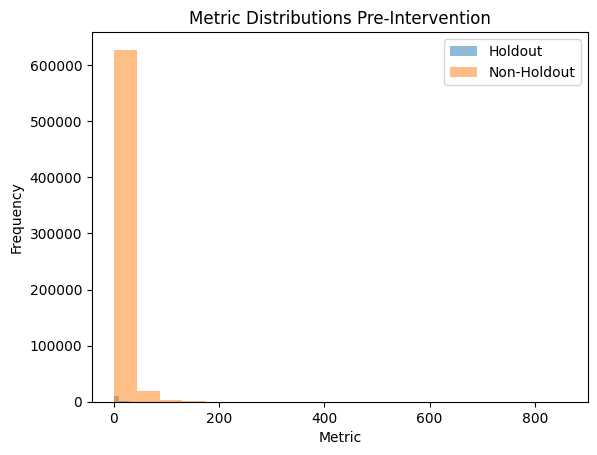

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

SG_pre = pre_holdout[pre_holdout['entity_id'] == 'FP_TH']

pre_intervention_df =  SG_pre.copy()

# Filter pre-intervention data
#pre_intervention_df = df[df['release_date'] < 'intervention_date']

# Group by holdout and non-holdout groups
group_metrics = pre_intervention_df.groupby('is_customer_holdout')['orders']

# Descriptive statistics
group_stats = group_metrics.describe()
print("Descriptive Statistics:\n", group_stats)

# T-test to compare means
holdout_metrics = pre_intervention_df[pre_intervention_df['is_customer_holdout'] == True]['orders']
non_holdout_metrics = pre_intervention_df[pre_intervention_df['is_customer_holdout'] == False]['orders']

t_stat, p_value = ttest_ind(holdout_metrics, non_holdout_metrics)
print(f"T-test Results:\nT-Statistic: {t_stat}, P-Value: {p_value}")

# Visualizing distributions
plt.hist(holdout_metrics, bins=20, alpha=0.5, label='Holdout')
plt.hist(non_holdout_metrics, bins=20, alpha=0.5, label='Non-Holdout')
plt.xlabel('Metric')
plt.ylabel('Frequency')
plt.legend()
plt.title('Metric Distributions Pre-Intervention')
plt.show()

In [128]:
post_holdout

"\nWITH eligible_holdout_entities AS (\n  SELECT\n        entity_id\n       ,`Release Date` as release_date\n  FROM `logistics-data-storage-staging.long_term_pricing.global_holdout_rollout`\n  WHERE `Release Date` < DATE_SUB(CURRENT_DATE(), INTERVAL EXTRACT(DAYOFWEEK FROM CURRENT_DATE())- 2 DAY)\n),\ncustomer_information AS (\n  SELECT\n         e.entity_id\n        ,e.release_date\n        ,customer_id\n        ,is_customer_holdout\n  FROM `fulfillment-dwh-production.cl.dps_holdout_users` AS d\n  JOIN eligible_holdout_entities AS e\n  ON d.entity_id = e.entity_id\n  WHERE d.created_date >= DATE('2025-01-01')\n  AND d.created_date >= e.release_date\n  AND customer_id IS NOT NULL\n)\nSELECT \n     dps.entity_id\n    ,dps.dps_customer_id\n    ,ci.is_customer_holdout\n    ,COUNT (DISTINCT platform_order_code) AS orders\n    ,SUM(fully_loaded_gross_profit_eur) AS flgp\nFROM `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` dps\njoin customer_information ci on ci.entity_id = dps

In [127]:
SG_post = post_holdout[post_holdout['entity_id'] == 'FP_SG']

post_intervention_df =  SG_post.copy()

# Filter pre-intervention data
#post_intervention_df = df[df['time_period'] < 'intervention_date']

# Group by holdout and non-holdout groups
group_metrics = post_intervention_df.groupby('is_customer_holdout')['flgp']

# Descriptive statistics
group_stats = group_metrics.describe()
print("Descriptive Statistics:\n", group_stats)

# T-test to compare means
holdout_metrics = post_intervention_df[post_intervention_df['is_customer_holdout'] == True]['flgp']
non_holdout_metrics = post_intervention_df[post_intervention_df['is_customer_holdout'] == False]['flgp']

t_stat, p_value = ttest_ind(holdout_metrics, non_holdout_metrics)
print(f"T-test Results:\nT-Statistic: {t_stat}, P-Value: {p_value}")

# Visualizing distributions
plt.hist(holdout_metrics, bins=20, alpha=0.5, label='Holdout')
plt.hist(non_holdout_metrics, bins=20, alpha=0.5, label='Non-Holdout')
plt.xlabel('Metric')
plt.ylabel('Frequency')
plt.legend()
plt.title('Metric Distributions Pre-Intervention')
plt.show()

TypeError: string indices must be integers, not 'str'